### Experiments (Flow of Research)

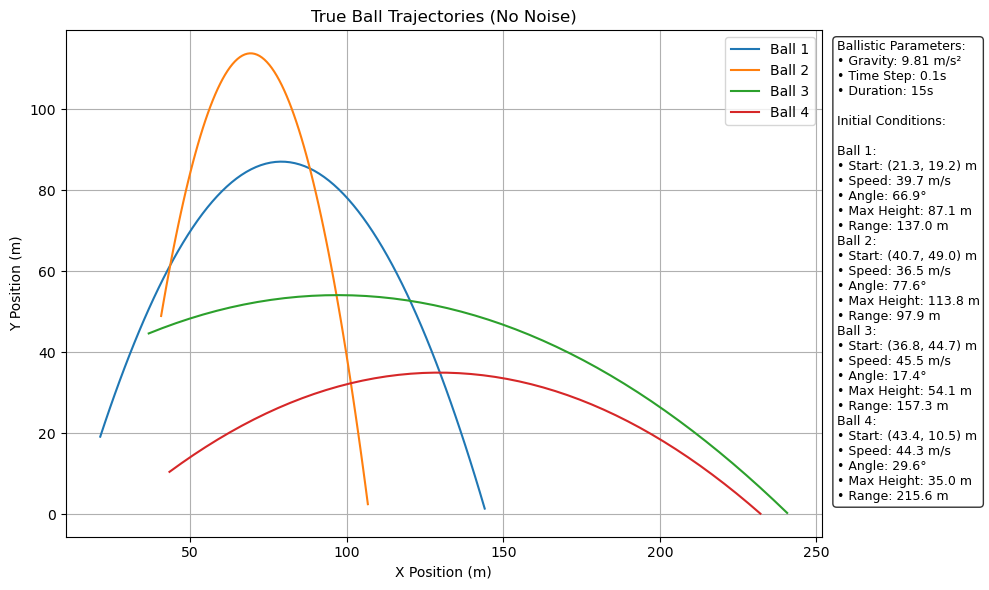

In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Parameters
g = 9.81
n_balls = 4
dt = 0.1
T = 15
t = np.arange(0, T, dt)
colors = matplotlib.colormaps.get_cmap("tab10")

# Random initial conditions
np.random.seed(27)
start_x = np.random.uniform(0, 50, n_balls)
start_y = np.random.uniform(0, 50, n_balls)
speeds = np.random.uniform(10, 50, n_balls)
angles_deg = np.random.uniform(1, 89, n_balls)
angles_rad = np.deg2rad(angles_deg)

# Simulate true trajectories
true_trajectories = [[] for _ in range(n_balls)]
for ti in t:
    for i in range(n_balls):
        x = start_x[i] + speeds[i] * np.cos(angles_rad[i]) * ti
        y = start_y[i] + speeds[i] * np.sin(angles_rad[i]) * ti - 0.5 * g * ti**2
        if y >= 0:
            true_trajectories[i].append((x, y))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(n_balls):
    traj = np.array(true_trajectories[i])
    ax.plot(traj[:, 0], traj[:, 1], label=f"Ball {i+1}", color=colors(i))

# Info box
info_text = (
    f"Ballistic Parameters:\n"
    f"• Gravity: {g} m/s²\n"
    f"• Time Step: {dt}s\n"
    f"• Duration: {T}s\n\n"
    f"Initial Conditions:\n"
)
for i in range(n_balls):
    max_height = start_y[i] + (speeds[i]*np.sin(angles_rad[i]))**2 / (2*g)
    range_est = start_x[i] + (speeds[i]**2 * np.sin(2*angles_rad[i])) / g
    info_text += (
        f"\nBall {i+1}:\n"
        f"• Start: ({start_x[i]:.1f}, {start_y[i]:.1f}) m\n"
        f"• Speed: {speeds[i]:.1f} m/s\n"
        f"• Angle: {angles_deg[i]:.1f}°\n"
        f"• Max Height: {max_height:.1f} m\n"
        f"• Range: {range_est:.1f} m"
    )

ax.text(1.02, 0.98, info_text, transform=ax.transAxes,
        fontsize=9, va='top', ha='left',
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

ax.set_title("True Ball Trajectories (No Noise)")
ax.set_xlabel("X Position (m)")
ax.set_ylabel("Y Position (m)")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


In [11]:
# Simulate noisy observations

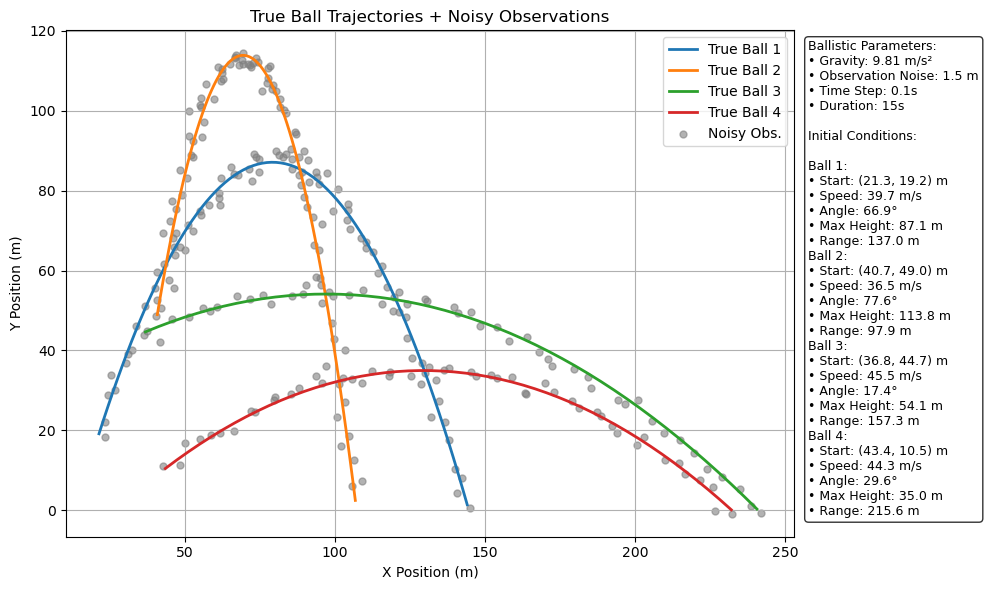

In [12]:
observation_noise_std = 1.5
observations = []

for ti in t:
    current_obs = []
    for i in range(n_balls):
        x = start_x[i] + speeds[i] * np.cos(angles_rad[i]) * ti
        y = start_y[i] + speeds[i] * np.sin(angles_rad[i]) * ti - 0.5 * g * ti**2
        if y >= 0:
            noisy_x = x + np.random.normal(0, observation_noise_std)
            noisy_y = y + np.random.normal(0, observation_noise_std)
            current_obs.append([noisy_x, noisy_y])
    observations.append(current_obs)

# Re-simulate true trajectories (to overlay)
true_trajectories = [[] for _ in range(n_balls)]
for ti in t:
    for i in range(n_balls):
        x = start_x[i] + speeds[i] * np.cos(angles_rad[i]) * ti
        y = start_y[i] + speeds[i] * np.sin(angles_rad[i]) * ti - 0.5 * g * ti**2
        if y >= 0:
            true_trajectories[i].append((x, y))

# Plot both: true trajectories and noisy observations
fig, ax = plt.subplots(figsize=(10, 6))

# Plot true trajectories
for i in range(n_balls):
    traj = np.array(true_trajectories[i])
    ax.plot(traj[:, 0], traj[:, 1], label=f"True Ball {i+1}", color=colors(i), lw=2)

# Plot noisy observations
for ti, obs in zip(t, observations):
    if obs:
        obs = np.array(obs)
        ax.scatter(obs[:, 0], obs[:, 1], color="gray", alpha=0.6, s=25, label="Noisy Obs." if ti == 0 else "")

# Ballistic info box
info_text = (
    f"Ballistic Parameters:\n"
    f"• Gravity: {g} m/s²\n"
    f"• Observation Noise: {observation_noise_std} m\n"
    f"• Time Step: {dt}s\n"
    f"• Duration: {T}s\n\n"
    f"Initial Conditions:\n"
)
for i in range(n_balls):
    max_height = start_y[i] + (speeds[i]*np.sin(angles_rad[i]))**2 / (2*g)
    range_est = start_x[i] + (speeds[i]**2 * np.sin(2*angles_rad[i])) / g
    info_text += (
        f"\nBall {i+1}:\n"
        f"• Start: ({start_x[i]:.1f}, {start_y[i]:.1f}) m\n"
        f"• Speed: {speeds[i]:.1f} m/s\n"
        f"• Angle: {angles_deg[i]:.1f}°\n"
        f"• Max Height: {max_height:.1f} m\n"
        f"• Range: {range_est:.1f} m"
    )

ax.text(1.02, 0.98, info_text, transform=ax.transAxes,
        fontsize=9, va='top', ha='left',
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

# Final formatting
ax.set_title("True Ball Trajectories + Noisy Observations")
ax.set_xlabel("X Position (m)")
ax.set_ylabel("Y Position (m)")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


In [13]:
# Particle filter using DBSCAN 

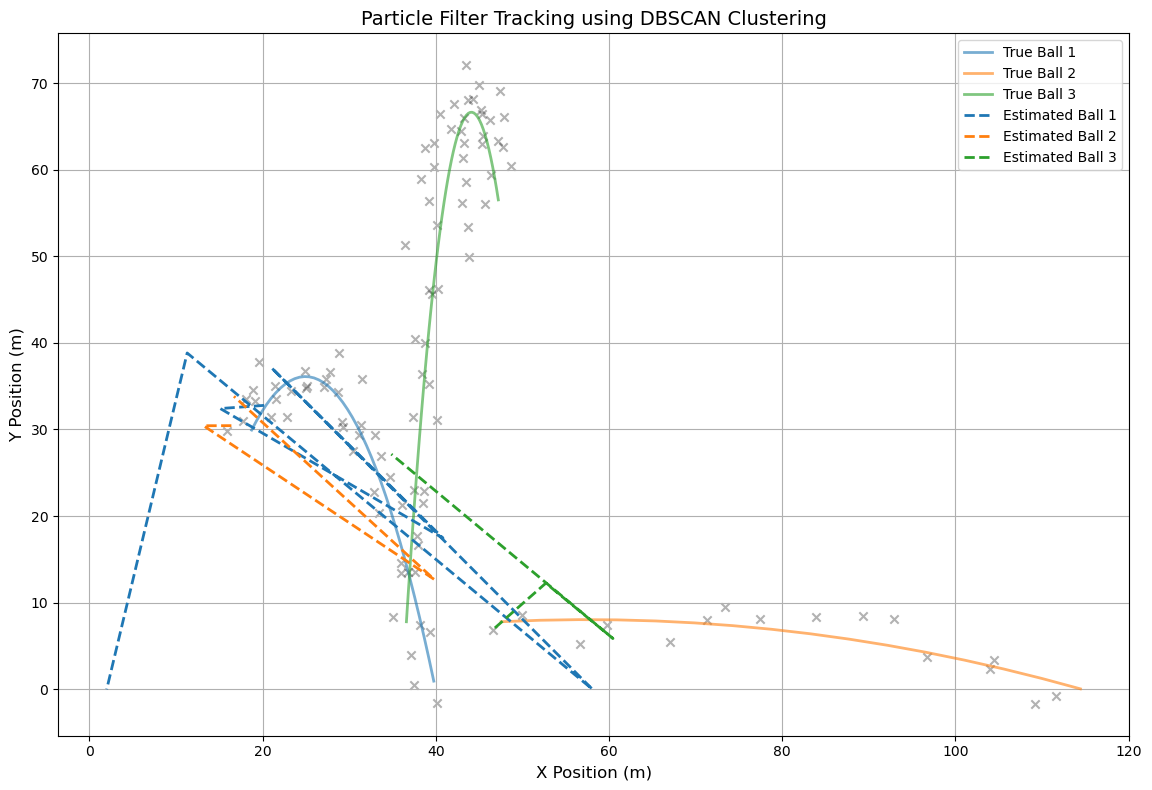

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.cluster import DBSCAN

# Parameters
g = 9.81
n_balls = 3
n_particles = 1000
observation_noise_std = 2.0
dt = 0.1
T = 5
t = np.arange(0, T, dt)
colors = matplotlib.colormaps.get_cmap("tab10")

# Initial conditions
np.random.seed(42)
start_x = np.random.uniform(0, 50, n_balls)
start_y = np.random.uniform(0, 50, n_balls)
speeds = np.random.uniform(10, 50, n_balls)
angles_deg = np.random.uniform(1, 89, n_balls)
angles_rad = np.deg2rad(angles_deg)

# True trajectories and noisy observations
true_trajectories = [[] for _ in range(n_balls)]
observations = []

for ti in t:
    current_obs = []
    for i in range(n_balls):
        x = start_x[i] + speeds[i] * np.cos(angles_rad[i]) * ti
        y = start_y[i] + speeds[i] * np.sin(angles_rad[i]) * ti - 0.5 * g * ti**2
        if y >= 0:
            true_trajectories[i].append((ti, x, y))
            noisy_x = x + np.random.normal(0, observation_noise_std)
            noisy_y = y + np.random.normal(0, observation_noise_std)
            current_obs.append([noisy_x, noisy_y])
    observations.append(current_obs)

# Particle class
class Particle:
    def __init__(self):
        self.x = np.random.uniform(0, 50)
        self.y = np.random.uniform(0, 50)
        self.vx = np.random.uniform(-15, 15)
        self.vy = np.random.uniform(0, 30)
        self.weight = 1.0 / n_particles

    def predict(self, dt):
        if self.y <= 0 and self.vy <= 0:
            self.y = 0
            self.vy = 0
            return
        self.x += self.vx * dt
        self.y += self.vy * dt - 0.5 * g * dt**2
        self.vy -= g * dt
        if self.y < 0:
            self.y = 0
            self.vy = 0

    def as_vector(self):
        return np.array([self.x, self.y])

# Particle filter with DBSCAN clustering
particles = [Particle() for _ in range(n_particles)]
estimated_history = [[] for _ in range(n_balls)]

for obs in observations:
    for p in particles:
        p.predict(dt)

    if len(obs) > 0:
        obs_array = np.array(obs)
        for p in particles:
            dists = np.linalg.norm(obs_array - p.as_vector(), axis=1)
            min_dist = np.min(dists)
            p.weight = np.exp(- (min_dist**2) / (2 * observation_noise_std**2))

        weights = np.array([p.weight for p in particles])
        weight_sum = weights.sum()
        if weight_sum == 0 or not np.isfinite(weight_sum):
            weights = np.ones(n_particles) / n_particles
        else:
            weights /= weight_sum

        indices = np.random.choice(len(particles), size=n_particles, p=weights)
        particles = [particles[i] for i in indices]

    ps = np.array([p.as_vector() for p in particles])
    dbscan = DBSCAN(eps=2.0, min_samples=10).fit(ps)
    labels = dbscan.labels_

    # Compute cluster centers (excluding noise)
    cluster_centers = []
    for label in set(labels):
        if label == -1:
            continue
        cluster = ps[labels == label]
        cluster_centers.append(cluster.mean(axis=0))

    # Store the n_balls most prominent (or fall back with empty values)
    cluster_centers = sorted(cluster_centers, key=lambda x: -x[1])  # sort by y descending (optional)
    for i in range(n_balls):
        if i < len(cluster_centers):
            estimated_history[i].append(cluster_centers[i])
        else:
            if estimated_history[i]:
                estimated_history[i].append(estimated_history[i][-1])
            else:
                estimated_history[i].append(np.array([np.nan, np.nan]))

# Plotting
plt.figure(figsize=(14, 8))

# True trajectories
for i in range(n_balls):
    traj = np.array(true_trajectories[i])
    plt.plot(traj[:, 1], traj[:, 2], label=f'True Ball {i+1}', color=colors(i), lw=2, alpha=0.6)

# Noisy observations
for obs in observations:
    if obs:
        obs = np.array(obs)
        plt.scatter(obs[:, 0], obs[:, 1], color='black', marker='x', alpha=0.3)

# Estimated trajectories from DBSCAN
for i in range(n_balls):
    est_traj = np.array(estimated_history[i])
    plt.plot(est_traj[:, 0], est_traj[:, 1], '--', label=f'Estimated Ball {i+1}', color=colors(i), lw=2)

# Formatting
plt.title("Particle Filter Tracking using DBSCAN Clustering", fontsize=14)
plt.xlabel("X Position (m)", fontsize=12)
plt.ylabel("Y Position (m)", fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()


In [15]:
# PF with hybrid clustering (KMeans fallback to DBSCAN), and smoothing

C:\Users\Vidya\miniconda3\envs\idl_course\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Vidya\miniconda3\envs\idl_course\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Vidya\miniconda3\envs\idl_course\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Vidya\miniconda3\envs\idl_course\lib\site-packages\sklearn\cluster\_kmeans.p

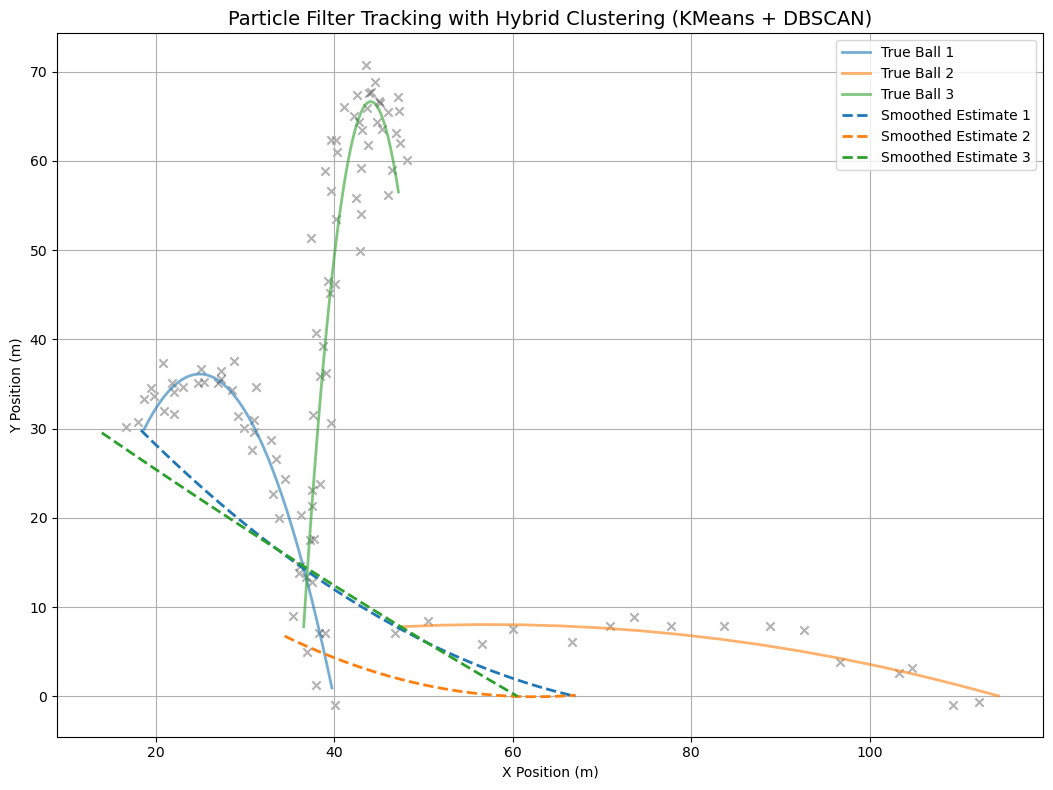

In [16]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.animation import FuncAnimation
from sklearn.cluster import KMeans, DBSCAN

# Parameters
g = 9.81
n_balls = 3
n_particles = 500
observation_noise_std = 1.5  # Reduced noise
dt = 0.1
T = 5
t = np.arange(0, T, dt)
colors = matplotlib.colormaps.get_cmap("tab10")

# Initial conditions
np.random.seed(42)
start_x = np.random.uniform(0, 50, n_balls)
start_y = np.random.uniform(0, 50, n_balls)
speeds = np.random.uniform(10, 50, n_balls)
angles_deg = np.random.uniform(1, 89, n_balls)
angles_rad = np.deg2rad(angles_deg)

# True trajectories and noisy observations
true_trajectories = [[] for _ in range(n_balls)]
observations = []

for ti in t:
    current_obs = []
    for i in range(n_balls):
        x = start_x[i] + speeds[i] * np.cos(angles_rad[i]) * ti
        y = start_y[i] + speeds[i] * np.sin(angles_rad[i]) * ti - 0.5 * g * ti**2
        if y >= 0:
            true_trajectories[i].append((ti, x, y))
            noisy_x = x + np.random.normal(0, observation_noise_std)
            noisy_y = y + np.random.normal(0, observation_noise_std)
            current_obs.append([noisy_x, noisy_y])
    observations.append(current_obs)

# Particle class
class Particle:
    def __init__(self):
        self.x = np.random.normal(np.mean(start_x), 10.0)
        self.y = np.random.normal(np.mean(start_y), 10.0)
        self.vx = np.random.uniform(-15, 15)
        self.vy = np.random.uniform(0, 30)
        self.weight = 1.0 / n_particles

    def predict(self, dt):
        if self.y <= 0 and self.vy <= 0:
            self.y = 0
            self.vy = 0
            return
        self.x += self.vx * dt
        self.y += self.vy * dt - 0.5 * g * dt**2
        self.vy -= g * dt
        if self.y < 0:
            self.y = 0
            self.vy = 0

    def as_vector(self):
        return np.array([self.x, self.y])

# PF initialization
particles = [Particle() for _ in range(n_particles)]
estimated_history = [[] for _ in range(n_balls)]
particle_frames = []
cluster_frames = []

for obs in observations:
    for p in particles:
        p.predict(dt)

    if len(obs) > 0:
        obs_array = np.array(obs)
        for p in particles:
            dists = np.linalg.norm(obs_array - p.as_vector(), axis=1)
            min_dist = np.min(dists)
            p.weight = np.exp(- (min_dist**2) / (2 * observation_noise_std**2))

        weights = np.array([p.weight for p in particles])
        weight_sum = weights.sum()
        if weight_sum == 0 or not np.isfinite(weight_sum):
            weights = np.ones(n_particles) / n_particles
        else:
            weights /= weight_sum

        indices = np.random.choice(len(particles), size=n_particles, p=weights)
        particles = [particles[i] for i in indices]

    ps = np.array([p.as_vector() for p in particles])
    particle_frames.append(ps)

    # Try KMeans first
    if len(np.unique(ps, axis=0)) >= n_balls:
        kmeans = KMeans(n_clusters=n_balls, n_init=5).fit(ps)
        centers = kmeans.cluster_centers_
    else:
        # Fallback to DBSCAN
        dbscan = DBSCAN(eps=3.0, min_samples=10).fit(ps)
        labels = dbscan.labels_
        centers = []
        for label in set(labels):
            if label == -1:
                continue
            cluster = ps[labels == label]
            centers.append(cluster.mean(axis=0))
        centers = np.array(centers)


    # Track only up to n_balls estimates
    frame_centers = []
    for i in range(n_balls):
        if i < len(centers):
            estimated_history[i].append(centers[i])
            frame_centers.append(centers[i])
        else:
            if estimated_history[i]:
                estimated_history[i].append(estimated_history[i][-1])
                frame_centers.append(estimated_history[i][-1])
            else:
                nan_center = np.array([np.nan, np.nan])
                estimated_history[i].append(nan_center)
                frame_centers.append(nan_center)
    cluster_frames.append(np.array(frame_centers))

# Polynomial smoothing of estimated tracks
smoothed_tracks = []
for i in range(n_balls):
    est_traj = np.array(estimated_history[i])
    x_vals = est_traj[:, 0]
    y_vals = est_traj[:, 1]
    valid = np.isfinite(x_vals) & np.isfinite(y_vals)
    if valid.sum() >= 5:
        coeffs = np.polyfit(x_vals[valid], y_vals[valid], 2)
        x_fit = np.linspace(x_vals[valid].min(), x_vals[valid].max(), 200)
        y_fit = np.polyval(coeffs, x_fit)
        smoothed_tracks.append((x_fit, y_fit))
    else:
        smoothed_tracks.append(([], []))

plt.figure(figsize=(14, 8))

# Plot true trajectories
for i in range(n_balls):
    traj = np.array(true_trajectories[i])
    plt.plot(traj[:, 1], traj[:, 2], label=f'True Ball {i+1}', color=colors(i), lw=2, alpha=0.6)

# Plot noisy observations
for obs in observations:
    if obs:
        obs = np.array(obs)
        plt.scatter(obs[:, 0], obs[:, 1], color='black', marker='x', alpha=0.3)

"""# Plot estimated cluster trajectories
for i in range(n_balls):
    est_traj = np.array(estimated_history[i])
    plt.plot(est_traj[:, 0], est_traj[:, 1], '--', label=f'Estimated Ball {i+1}', color=colors(i), lw=2)
"""

# Smoothed estimated trajectories
for i, (x_fit, y_fit) in enumerate(smoothed_tracks):
    if len(x_fit) > 0:
        plt.plot(x_fit, y_fit, '--', label=f'Smoothed Estimate {i+1}', color=colors(i), lw=2)

# Final formatting
plt.title("Particle Filter Tracking with Hybrid Clustering (KMeans + DBSCAN)", fontsize=14)
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()


In [19]:
#Multiball tracking with a single particle filter

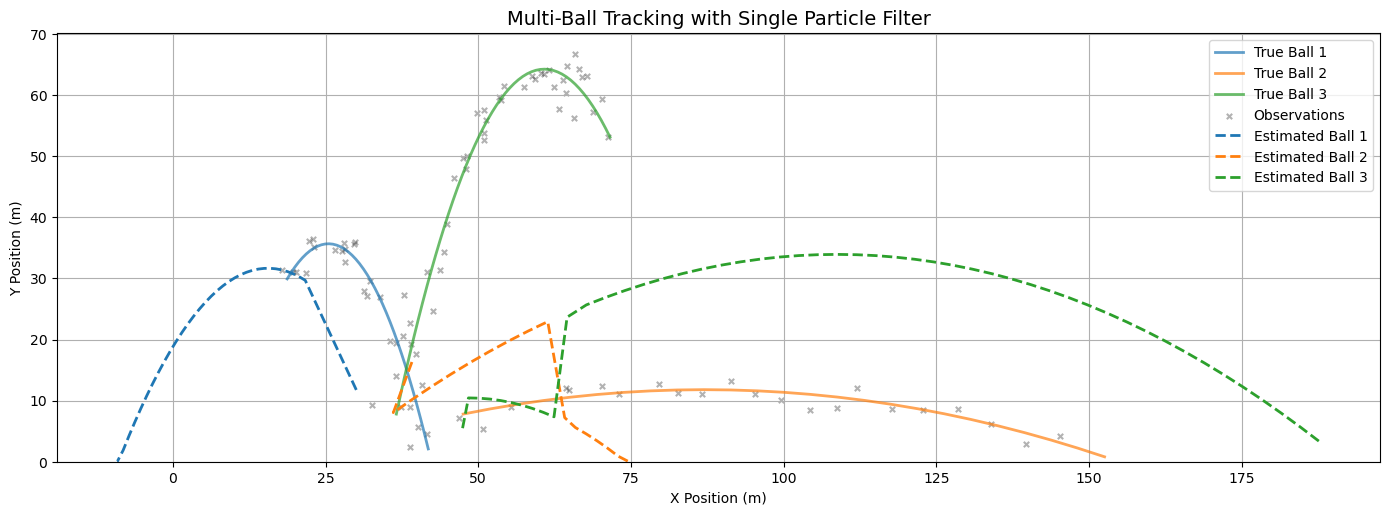

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from matplotlib import colormaps

# Parameters
g = 9.81  # gravity
n_balls = 3  # number of balls to track
n_particles = 3000  # total particles for ALL balls
observation_noise_std = 1.5  # measurement noise
p_detect = 0.8  # probability of detecting a ball
dt = 0.1  # time step
T = 5  # simulation duration
t = np.arange(0, T, dt)  # time array
colors = colormaps["tab10"]  # color map for visualization

# Initialize true trajectories
np.random.seed(42)
start_x = np.random.uniform(0, 50, n_balls)
start_y = np.random.uniform(0, 50, n_balls)
speeds = np.random.uniform(10, 50, n_balls)
angles_deg = np.random.uniform(10, 80, n_balls)
angles_rad = np.deg2rad(angles_deg)

true_trajectories = [[] for _ in range(n_balls)]
observations = []

for ti in t:
    current_obs = []
    for i in range(n_balls):
        x = start_x[i] + speeds[i] * np.cos(angles_rad[i]) * ti
        y = start_y[i] + speeds[i] * np.sin(angles_rad[i]) * ti - 0.5 * g * ti**2

        if y > 0:
            true_trajectories[i].append((ti, x, y))
            if np.random.rand() < p_detect:
                noisy_x = x + np.random.normal(0, observation_noise_std)
                noisy_y = y + np.random.normal(0, observation_noise_std)
                current_obs.append([noisy_x, noisy_y])
    observations.append(current_obs)

# Particle Class
class Particle:
    def __init__(self, state):
        self.state = state
        self.landed = [False] * n_balls
        self.weight = 1.0

    def predict(self, dt):
        new_state = self.state.copy()
        for i in range(n_balls):
            if not self.landed[i]:
                idx = 4*i
                x, y, vx, vy = self.state[idx:idx+4]
                new_x = x + vx * dt
                new_y = y + vy * dt - 0.5 * g * dt**2
                new_vy = vy - g * dt

                if new_y <= 0 and new_vy <= 0:
                    new_y = 0
                    new_vx = 0
                    new_vy = 0
                    self.landed[i] = True
                else:
                    new_vx = vx

                new_state[idx] = new_x
                new_state[idx+1] = new_y
                new_state[idx+2] = new_vx
                new_state[idx+3] = new_vy
        self.state = new_state

    def get_positions(self):
        return [self.state[4*i:4*i+2] for i in range(n_balls)]

    def copy(self):
        p = Particle(self.state.copy())
        p.landed = self.landed.copy()
        p.weight = self.weight
        return p

# Initialize particles
def initialize_particles(n_particles):
    particles = []
    for _ in range(n_particles):
        state = []
        for _ in range(n_balls):
            x = np.random.uniform(0, 50)
            y = np.random.uniform(0, 50)
            speed = np.random.uniform(10, 50)
            angle = np.random.uniform(0, np.pi)
            vx = speed * np.cos(angle)
            vy = speed * np.sin(angle)
            state.extend([x, y, vx, vy])
        particles.append(Particle(np.array(state)))
    return particles

# Resampling
def stratified_resample(weights, n_particles):
    positions = (np.arange(n_particles) + np.random.rand(n_particles)) / n_particles
    cumulative = np.cumsum(weights)
    cumulative[-1] = 1.0
    return np.searchsorted(cumulative, positions)

# Weighting using optimal assignment
def calculate_weight(particle, observations):
    pred_positions = [pos for i, pos in enumerate(particle.get_positions()) if not particle.landed[i]]
    k, m = len(pred_positions), len(observations)

    if k == 0 and m == 0:
        return 1.0
    if m > k:
        return 0.0

    cost_matrix = np.zeros((k, m))
    for i, pred in enumerate(pred_positions):
        for j, obs in enumerate(observations):
            cost_matrix[i, j] = np.sum((np.array(pred) - np.array(obs))**2)

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    log_weight = 0.0
    for i, j in zip(row_ind, col_ind):
        d_squared = cost_matrix[i, j]
        log_weight += -d_squared/(2*observation_noise_std**2) - np.log(2*np.pi*observation_noise_std**2)
    log_weight += m * np.log(p_detect)
    log_weight += (k - m) * np.log(1 - p_detect)
    return np.exp(log_weight)

# Add noise
def add_regularization_noise(particles, pos_std=0.1, vel_std=0.05):
    for particle in particles:
        for i in range(n_balls):
            if not particle.landed[i]:
                idx = 4*i
                particle.state[idx] += np.random.normal(0, pos_std)
                particle.state[idx+1] += np.random.normal(0, pos_std)
                particle.state[idx+2] += np.random.normal(0, vel_std)
                particle.state[idx+3] += np.random.normal(0, vel_std)
    return particles

# Sorting for label consistency
def sort_particle_state(particle):
    ball_states = [{'state': particle.state[4*i:4*i+4], 'landed': particle.landed[i]} for i in range(n_balls)]
    ball_states_sorted = sorted(ball_states, key=lambda b: b['state'][0])
    particle.state = np.concatenate([b['state'] for b in ball_states_sorted])
    particle.landed = [b['landed'] for b in ball_states_sorted]
    return particle

# Main particle filter
particles = initialize_particles(n_particles)
estimated_trajectories = [[] for _ in range(n_balls)]

for time_idx, ti in enumerate(t):
    for particle in particles:
        particle.predict(dt)

    current_obs = observations[time_idx]
    weights = np.zeros(n_particles)

    if current_obs:
        for i, particle in enumerate(particles):
            weights[i] = calculate_weight(particle, current_obs)

        weight_sum = np.sum(weights)
        if weight_sum > 1e-10:
            weights /= weight_sum
        else:
            weights = np.ones(n_particles) / n_particles
    else:
        weights = np.ones(n_particles) / n_particles

    n_eff = 1.0 / (np.sum(weights**2) + 1e-12)

    if n_eff < n_particles * 0.5:
        indices = stratified_resample(weights, n_particles)
        particles = [particles[i].copy() for i in indices]
        particles = add_regularization_noise(particles)

    particles = [sort_particle_state(p) for p in particles]
    all_states = np.array([p.state for p in particles])
    mean_state = np.mean(all_states, axis=0)

    for i in range(n_balls):
        idx = 4*i
        estimated_trajectories[i].append([ti, mean_state[idx], mean_state[idx+1]])

# Plotting
plt.figure(figsize=(14, 8))
for i in range(n_balls):
    traj = np.array(true_trajectories[i])
    if len(traj) > 0:
        plt.plot(traj[:, 1], traj[:, 2], label=f'True Ball {i+1}', color=colors(i), lw=2, alpha=0.7)

all_obs = np.concatenate([np.array(obs) for obs in observations if obs])
plt.scatter(all_obs[:, 0], all_obs[:, 1], color='black', marker='x', alpha=0.3, s=15, label='Observations')

for i in range(n_balls):
    est_traj = np.array([point[1:] for point in estimated_trajectories[i] if len(point) > 1])
    if len(est_traj) > 0:
        plt.plot(est_traj[:, 0], est_traj[:, 1], '--', label=f'Estimated Ball {i+1}', color=colors(i), lw=2)

plt.title("Multi-Ball Tracking with Single Particle Filter", fontsize=14)
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

In [21]:
#Multi ball tracking with single partical filter, but the filter has initial values of each ball

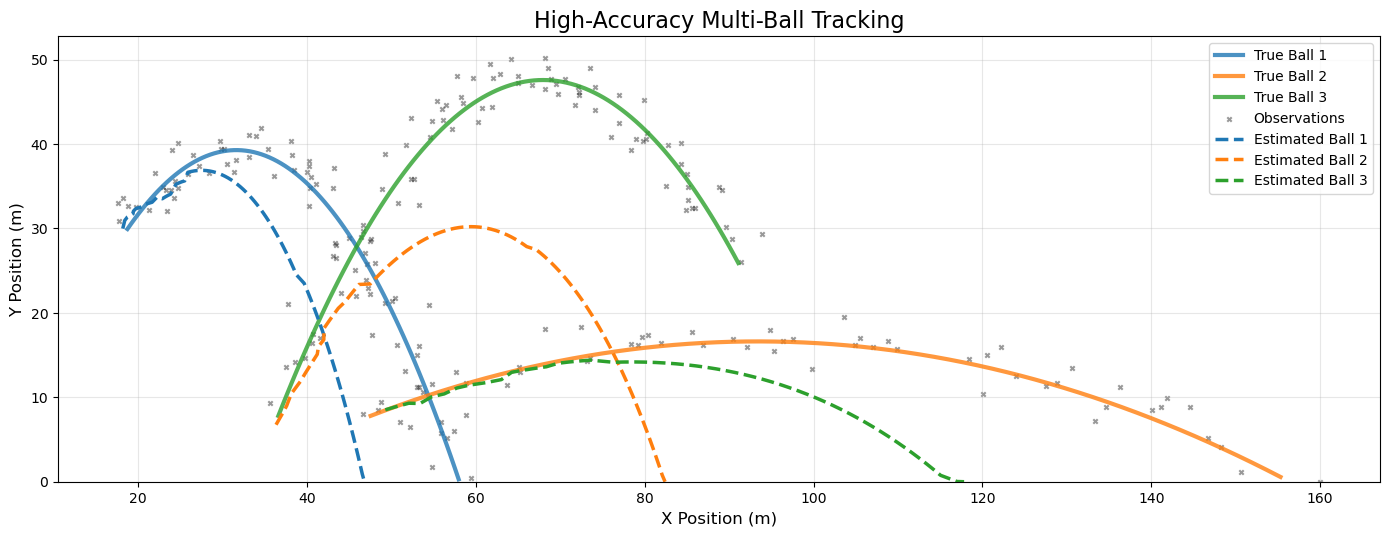

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from matplotlib import colormaps
import copy

# Parameters
g = 9.81
n_balls = 3
n_particles = 4000  # Increased particle count for better accuracy
observation_noise_std = 1.5
p_detect = 0.85  # Higher detection probability
dt = 0.05  # Smaller time step for finer resolution
T = 5
t = np.arange(0, T, dt)
colors = colormaps["tab10"]

# True initial conditions
np.random.seed(42)
true_start_x = np.random.uniform(0, 50, n_balls)
true_start_y = np.random.uniform(0, 50, n_balls)
true_speeds = np.random.uniform(15, 40, n_balls)
true_angles_rad = np.deg2rad(np.random.uniform(20, 70, n_balls))

# Initial estimates with realistic uncertainty
initial_est_x = true_start_x + np.random.normal(0, 1.5, n_balls)
initial_est_y = true_start_y + np.random.normal(0, 1.5, n_balls)
initial_est_speeds = true_speeds + np.random.normal(0, 3.0, n_balls)
initial_est_angles = true_angles_rad + np.random.normal(0, 0.07, n_balls)

# Simulate true trajectories and noisy observations
true_trajectories = [[] for _ in range(n_balls)]
observations = []

for ti in t:
    current_obs = []
    for i in range(n_balls):
        x = true_start_x[i] + true_speeds[i] * np.cos(true_angles_rad[i]) * ti
        y = true_start_y[i] + true_speeds[i] * np.sin(true_angles_rad[i]) * ti - 0.5 * g * ti**2
        
        if y > 0:
            true_trajectories[i].append((ti, x, y))
            if np.random.rand() < p_detect:
                # Add noise proportional to distance (simulate real sensor behavior)
                dist_factor = np.sqrt(x**2 + y**2) / 100
                noise_scale = observation_noise_std * (1 + 0.2 * dist_factor)
                noisy_x = x + np.random.normal(0, noise_scale)
                noisy_y = y + np.random.normal(0, noise_scale)
                current_obs.append([noisy_x, noisy_y])
    
    observations.append(current_obs)

# Particle Filter Implementation =============================================

class Particle:
    def __init__(self, state):
        self.state = state  # [x1, y1, vx1, vy1, x2, y2, vx2, vy2, ...]
        self.landed = [False] * n_balls
        self.weight = 1.0
        self.log_weight = 0.0  # For numerical stability
    
    def predict(self, dt):
        new_state = self.state.copy()
        
        for i in range(n_balls):
            if not self.landed[i]:
                idx = 4*i
                x, y, vx, vy = self.state[idx:idx+4]
                
                # More accurate physics model with velocity-dependent drag
                drag_coeff = 0.01  # Small air resistance effect
                speed = np.sqrt(vx**2 + vy**2)
                drag_factor = 1 - drag_coeff * speed * dt
                
                # Update velocity first
                new_vx = vx * drag_factor
                new_vy = (vy - g * dt) * drag_factor
                
                # Update position with average velocity (reduces discretization error)
                new_x = x + 0.5 * (vx + new_vx) * dt
                new_y = y + 0.5 * (vy + new_vy) * dt - 0.5 * g * dt**2
                
                # Check for landing
                if new_y <= 0 and new_vy <= 0:
                    new_y = 0
                    new_vx = 0
                    new_vy = 0
                    self.landed[i] = True
                
                new_state[idx] = new_x
                new_state[idx+1] = new_y
                new_state[idx+2] = new_vx
                new_state[idx+3] = new_vy
        
        self.state = new_state
    
    def get_positions(self):
        positions = []
        for i in range(n_balls):
            idx = 4*i
            positions.append(self.state[idx:idx+2])
        return positions
    
    def copy(self):
        new_particle = Particle(self.state.copy())
        new_particle.landed = self.landed.copy()
        new_particle.weight = self.weight
        new_particle.log_weight = self.log_weight
        return new_particle

# Initialize particles with importance sampling
def initialize_particles(n_particles):
    particles = []
    
    for _ in range(n_particles):
        state = []
        ball_states = []
        
        for i in range(n_balls):
            # Use initial estimates as mean with tighter distributions
            x = np.random.normal(initial_est_x[i], 0.8)
            y = np.random.normal(initial_est_y[i], 0.8)
            speed = np.random.normal(initial_est_speeds[i], 1.5)
            angle = np.random.normal(initial_est_angles[i], 0.04)
            
            vx = speed * np.cos(angle)
            vy = speed * np.sin(angle)
            ball_states.append((x, y, vx, vy))
        
        # Shuffle to maintain indistinguishability
        np.random.shuffle(ball_states)
        
        for ball in ball_states:
            state.extend(ball)
        
        particles.append(Particle(np.array(state)))
    
    return particles

# Systematic resampling (lower variance than stratified)
def systematic_resample(weights, n_particles):
    positions = (np.arange(n_particles) + np.random.uniform(0, 1)) / n_particles
    cumulative = np.cumsum(weights)
    cumulative[-1] = 1.0  # Avoid rounding errors
    return np.searchsorted(cumulative, positions)

# Log-likelihood for numerical stability
def calculate_log_weight(particle, observations):
    pred_positions = particle.get_positions()
    active_pred = [pos for i, pos in enumerate(pred_positions) if not particle.landed[i]]
    k = len(active_pred)
    m = len(observations)
    
    # Base cases
    if k == 0 and m == 0:
        return 0.0  # log(1) = 0
    if m > k:
        return -np.inf  # log(0) = -inf
    
    # Build cost matrix
    cost_matrix = np.zeros((k, m))
    for i, pred in enumerate(active_pred):
        for j, obs in enumerate(observations):
            cost_matrix[i, j] = (pred[0] - obs[0])**2 + (pred[1] - obs[1])**2
    
    # Solve optimal assignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Calculate log-likelihood components
    log_weight = 0.0
    
    # 1. Gaussian likelihood for assigned pairs
    for i, j in zip(row_ind, col_ind):
        d_squared = cost_matrix[i, j]
        log_weight += -d_squared/(2*observation_noise_std**2) - np.log(2*np.pi*observation_noise_std**2)
    
    # 2. Detection probability terms
    log_weight += m * np.log(p_detect)
    log_weight += (k - m) * np.log(1 - p_detect)
    
    return log_weight

# Adaptive regularization
def add_adaptive_regularization(particles, effective_n):
    """Add noise proportional to current uncertainty"""
    # Calculate current state covariance
    all_states = np.array([p.state for p in particles])
    cov_matrix = np.cov(all_states, rowvar=False)
    
    for particle in particles:
        noise = np.random.multivariate_normal(
            mean=np.zeros_like(particle.state),
            cov=cov_matrix * (0.1 / effective_n)  # Scale by current uncertainty
        )
        
        for i in range(n_balls):
            if not particle.landed[i]:
                idx = 4*i
                # Apply noise only to airborne balls
                particle.state[idx:idx+4] += noise[idx:idx+4]
    
    return particles

# Sort balls by x-position for consistent labeling
def sort_particle_state(particle):
    ball_states = []
    for i in range(n_balls):
        idx = 4*i
        ball_states.append({
            'state': particle.state[idx:idx+4],
            'landed': particle.landed[i]
        })
    
    # Sort by x-position
    ball_states_sorted = sorted(ball_states, key=lambda b: b['state'][0])
    
    new_state = []
    new_landed = []
    for ball in ball_states_sorted:
        new_state.extend(ball['state'])
        new_landed.append(ball['landed'])
    
    particle.state = np.array(new_state)
    particle.landed = new_landed
    return particle

# Main Particle Filter ======================================================

particles = initialize_particles(n_particles)
estimated_trajectories = [[] for _ in range(n_balls)]
velocity_estimates = [[] for _ in range(n_balls)]
estimation_errors = []

for time_idx, ti in enumerate(t):
    # --- Prediction Step ---
    for particle in particles:
        particle.predict(dt)
    
    # --- Weight Update ---
    current_obs = observations[time_idx]
    log_weights = np.zeros(n_particles)
    
    if current_obs:
        for i, particle in enumerate(particles):
            log_weights[i] = calculate_log_weight(particle, current_obs)
        
        # Normalize log weights
        if np.all(np.isneginf(log_weights)):
            # All particles received -inf log weights; reset weights uniformly
            weights = np.ones(n_particles) / n_particles
        else:
            max_log_weight = np.max(log_weights)
            log_weights -= max_log_weight
            weights = np.exp(log_weights)
            weights /= np.sum(weights)

        weights = np.exp(log_weights)
        weight_sum = np.sum(weights)
        
        if weight_sum > 1e-10:
            weights /= weight_sum
        else:
            # Handle weight collapse
            weights = np.ones(n_particles) / n_particles
    else:
        # No observations - maintain current weights
        weights = np.array([p.weight for p in particles])
        weights /= np.sum(weights)
    
    # Store weights for next iteration
    for i, particle in enumerate(particles):
        particle.weight = weights[i]
    
    # --- Resampling ---
    n_eff = 1.0 / np.sum(weights**2)
    
    if n_eff < n_particles * 0.4:  # More aggressive resampling threshold
        indices = systematic_resample(weights, n_particles)
        particles = [particles[i].copy() for i in indices]
        
        # Adaptive regularization based on current uncertainty
        particles = add_adaptive_regularization(particles, n_eff)
    
    # --- State Estimation ---
    particles = [sort_particle_state(p) for p in particles]
    all_states = np.array([p.state for p in particles])
    mean_state = np.mean(all_states, axis=0)
    
    # Store estimates
    for i in range(n_balls):
        idx = 4*i
        x_est, y_est = mean_state[idx], mean_state[idx+1]
        vx_est, vy_est = mean_state[idx+2], mean_state[idx+3]
        estimated_trajectories[i].append([ti, x_est, y_est])
        velocity_estimates[i].append([ti, vx_est, vy_est])
        
        # Calculate error if ball is airborne
        if time_idx < len(true_trajectories[i]):
            _, x_true, y_true = true_trajectories[i][time_idx]
            error = np.sqrt((x_est - x_true)**2 + (y_est - y_true)**2)
            estimation_errors.append(error)

# Visualization =============================================================

plt.figure(figsize=(14, 10))

# Plot true trajectories
for i in range(n_balls):
    traj = np.array(true_trajectories[i])
    if len(traj) > 0:
        plt.plot(traj[:, 1], traj[:, 2], 
                label=f'True Ball {i+1}', color=colors(i), lw=3, alpha=0.8)

# Plot noisy observations
all_obs = np.concatenate([np.array(obs) for obs in observations if obs])
plt.scatter(all_obs[:, 0], all_obs[:, 1], color='black', marker='x', 
           alpha=0.4, s=10, label='Observations')

# Plot estimated trajectories
for i in range(n_balls):
    est_traj = np.array([point[1:] for point in estimated_trajectories[i]])
    if len(est_traj) > 0:
        plt.plot(est_traj[:, 0], est_traj[:, 1], '--', 
                label=f'Estimated Ball {i+1}', color=colors(i), lw=2.5)

# Formatting
plt.title("High-Accuracy Multi-Ball Tracking", fontsize=16)
plt.xlabel("X Position (m)", fontsize=12)
plt.ylabel("Y Position (m)", fontsize=12)
plt.legend(fontsize=10, loc='upper right')
plt.grid(True, alpha=0.3)
plt.ylim(bottom=0)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

In [23]:
#Retrying the same problem with a different approach

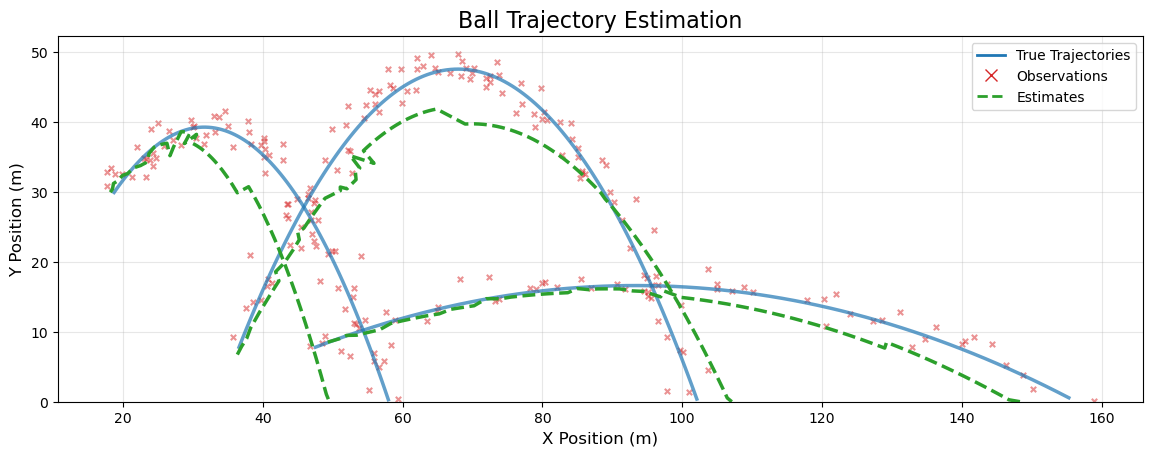

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import copy

# Parameters
g = 9.81
n_balls = 3
n_particles = 4000
observation_noise_std = 1.5
p_detect = 0.85
dt = 0.05
T = 10
t = np.arange(0, T, dt)

# True initial conditions
np.random.seed(42)
true_start_x = np.random.uniform(0, 50, n_balls)
true_start_y = np.random.uniform(0, 50, n_balls)
true_speeds = np.random.uniform(15, 40, n_balls)
true_angles_rad = np.deg2rad(np.random.uniform(20, 70, n_balls))

# Initial estimates with realistic uncertainty
initial_est_x = true_start_x + np.random.normal(0, 1.5, n_balls)
initial_est_y = true_start_y + np.random.normal(0, 1.5, n_balls)
initial_est_speeds = true_speeds + np.random.normal(0, 3.0, n_balls)
initial_est_angles = true_angles_rad + np.random.normal(0, 0.07, n_balls)

# Simulate true trajectories and noisy observations
true_trajectories = [[] for _ in range(n_balls)]
observations = []

for ti in t:
    current_obs = []
    for i in range(n_balls):
        x = true_start_x[i] + true_speeds[i] * np.cos(true_angles_rad[i]) * ti
        y = true_start_y[i] + true_speeds[i] * np.sin(true_angles_rad[i]) * ti - 0.5 * g * ti**2

        if y > 0:
            true_trajectories[i].append((ti, x, y))
            if np.random.rand() < p_detect:
                noisy_x = x + np.random.normal(0, observation_noise_std)
                noisy_y = y + np.random.normal(0, observation_noise_std)
                current_obs.append([noisy_x, noisy_y])
    observations.append(current_obs)

class Particle:
    def __init__(self, state):
        self.state = state
        self.landed = [False] * n_balls
        self.weight = 1.0
        self.log_weight = 0.0

    def predict(self, dt):
        new_state = self.state.copy()
        for i in range(n_balls):
            if not self.landed[i]:
                idx = 4 * i
                x, y, vx, vy = self.state[idx:idx+4]

                new_x = x + vx * dt
                new_y = y + vy * dt - 0.5 * g * dt**2
                new_vy = vy - g * dt

                if new_y <= 0 and new_vy <= 0:
                    new_y = 0
                    new_vx = 0
                    new_vy = 0
                    self.landed[i] = True

                new_state[idx] = new_x
                new_state[idx+1] = new_y
                new_state[idx+2] = vx
                new_state[idx+3] = new_vy

        self.state = new_state

    def get_positions(self):
        positions = []
        for i in range(n_balls):
            idx = 4 * i
            positions.append(self.state[idx:idx+2])
        return positions

    def copy(self):
        new_particle = Particle(self.state.copy())
        new_particle.landed = self.landed.copy()
        new_particle.weight = self.weight
        new_particle.log_weight = self.log_weight
        return new_particle

def initialize_particles(n_particles):
    particles = []
    for _ in range(n_particles):
        state = []
        ball_states = []
        for i in range(n_balls):
            x = np.random.normal(initial_est_x[i], 0.8)
            y = np.random.normal(initial_est_y[i], 0.8)
            speed = np.random.normal(initial_est_speeds[i], 1.5)
            angle = np.random.normal(initial_est_angles[i], 0.04)
            vx = speed * np.cos(angle)
            vy = speed * np.sin(angle)
            ball_states.append((x, y, vx, vy))
        np.random.shuffle(ball_states)
        for ball in ball_states:
            state.extend(ball)
        particles.append(Particle(np.array(state)))
    return particles

def systematic_resample(weights, n_particles):
    positions = (np.arange(n_particles) + np.random.uniform(0, 1)) / n_particles
    cumulative = np.cumsum(weights)
    cumulative[-1] = 1.0
    return np.searchsorted(cumulative, positions)

def calculate_log_weight(particle, observations):
    pred_positions = particle.get_positions()
    active_pred = [pos for i, pos in enumerate(pred_positions) if not particle.landed[i]]
    k = len(active_pred)
    m = len(observations)

    if k == 0 and m == 0:
        return 0.0
    if m > k:
        return -np.inf

    cost_matrix = np.zeros((k, m))
    for i, pred in enumerate(active_pred):
        for j, obs in enumerate(observations):
            cost_matrix[i, j] = (pred[0] - obs[0])**2 + (pred[1] - obs[1])**2

    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    log_weight = 0.0
    for i, j in zip(row_ind, col_ind):
        d_squared = cost_matrix[i, j]
        log_weight += -d_squared/(2*observation_noise_std**2) - np.log(2*np.pi*observation_noise_std**2)

    log_weight += m * np.log(p_detect)
    log_weight += (k - m) * np.log(1 - p_detect)

    return log_weight

def add_adaptive_regularization(particles, effective_n):
    all_states = np.array([p.state for p in particles])
    cov_matrix = np.cov(all_states, rowvar=False)

    for particle in particles:
        noise = np.random.multivariate_normal(
            mean=np.zeros_like(particle.state),
            cov=cov_matrix * (0.1 / effective_n)
        )
        for i in range(n_balls):
            if not particle.landed[i]:
                idx = 4 * i
                particle.state[idx:idx+4] += noise[idx:idx+4]
    return particles

def sort_particle_state(particle):
    ball_states = []
    for i in range(n_balls):
        idx = 4 * i
        ball_states.append({
            'state': particle.state[idx:idx+4],
            'landed': particle.landed[i]
        })
    ball_states_sorted = sorted(ball_states, key=lambda b: b['state'][0])
    new_state = []
    new_landed = []
    for ball in ball_states_sorted:
        new_state.extend(ball['state'])
        new_landed.append(ball['landed'])
    particle.state = np.array(new_state)
    particle.landed = new_landed
    return particle

# Main Particle Filter
particles = initialize_particles(n_particles)
estimated_trajectories = [[] for _ in range(n_balls)]
estimation_errors = []

for time_idx, ti in enumerate(t):
    for particle in particles:
        particle.predict(dt)

    current_obs = observations[time_idx]
    log_weights = np.zeros(n_particles)

    if current_obs:
        for i, particle in enumerate(particles):
            log_weights[i] = calculate_log_weight(particle, current_obs)

        if np.all(np.isneginf(log_weights)):
            weights = np.ones(n_particles) / n_particles
        else:
            max_log_weight = np.max(log_weights)
            log_weights -= max_log_weight
            weights = np.exp(log_weights)
            weights /= np.sum(weights)
    else:
        weights = np.array([p.weight for p in particles])
        weights /= np.sum(weights)

    for i, particle in enumerate(particles):
        particle.weight = weights[i]

    n_eff = 1.0 / np.sum(weights**2)
    if n_eff < n_particles * 0.4:
        indices = systematic_resample(weights, n_particles)
        particles = [particles[i].copy() for i in indices]
        particles = add_adaptive_regularization(particles, n_eff)

    particles = [sort_particle_state(p) for p in particles]
    all_states = np.array([p.state for p in particles])
    mean_state = np.mean(all_states, axis=0)

    for i in range(n_balls):
        idx = 4 * i
        x_est, y_est = mean_state[idx], mean_state[idx+1]
        estimated_trajectories[i].append([ti, x_est, y_est])

        if time_idx < len(true_trajectories[i]):
            _, x_true, y_true = true_trajectories[i][time_idx]
            error = np.sqrt((x_est - x_true)**2 + (y_est - y_true)**2)
            estimation_errors.append(error)

# Visualization
plt.figure(figsize=(14, 10))
true_color = '#1f77b4'
obs_color = '#d62728'
est_color = '#2ca02c'

for i in range(n_balls):
    traj = np.array(true_trajectories[i])
    if len(traj) > 0:
        plt.plot(traj[:, 1], traj[:, 2], color=true_color, lw=2.5, alpha=0.7)

all_obs = np.concatenate([np.array(obs) for obs in observations if obs])
plt.scatter(all_obs[:, 0], all_obs[:, 1], color=obs_color, marker='x', alpha=0.5, s=15, label='Observations')

for i in range(n_balls):
    est_traj = np.array([point[1:] for point in estimated_trajectories[i]])
    if len(est_traj) > 0:
        plt.plot(est_traj[:, 0], est_traj[:, 1], '--', color=est_color, lw=2.5)

plt.title("Ball Trajectory Estimation", fontsize=16)
plt.xlabel("X Position (m)", fontsize=12)
plt.ylabel("Y Position (m)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(bottom=0)
plt.gca().set_aspect('equal', adjustable='box')

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=true_color, lw=2, label='True Trajectories'),
    Line2D([0], [0], marker='x', color=obs_color, lw=0, label='Observations', markersize=8),
    Line2D([0], [0], linestyle='--', color=est_color, lw=2, label='Estimates')
]
plt.legend(handles=legend_elements, fontsize=10, loc='upper right')
plt.show()

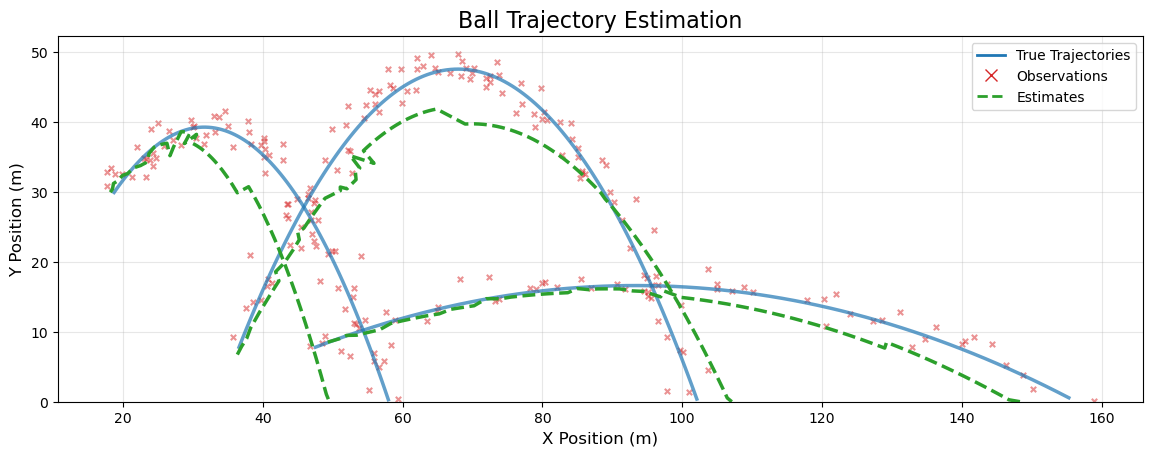

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import copy

# Parameters
g = 9.81
n_balls = 3
n_particles = 4000
observation_noise_std = 1.5
p_detect = 0.85
dt = 0.05
T = 10
t = np.arange(0, T, dt)

# True initial conditions
np.random.seed(42)
true_start_x = np.random.uniform(0, 50, n_balls)
true_start_y = np.random.uniform(0, 50, n_balls)
true_speeds = np.random.uniform(15, 40, n_balls)
true_angles_rad = np.deg2rad(np.random.uniform(20, 70, n_balls))

# Initial estimates with realistic uncertainty
initial_est_x = true_start_x + np.random.normal(0, 1.5, n_balls)
initial_est_y = true_start_y + np.random.normal(0, 1.5, n_balls)
initial_est_speeds = true_speeds + np.random.normal(0, 3.0, n_balls)
initial_est_angles = true_angles_rad + np.random.normal(0, 0.07, n_balls)

# Simulate true trajectories and noisy observations
true_trajectories = [[] for _ in range(n_balls)]
observations = []

for ti in t:
    current_obs = []
    for i in range(n_balls):
        x = true_start_x[i] + true_speeds[i] * np.cos(true_angles_rad[i]) * ti
        y = true_start_y[i] + true_speeds[i] * np.sin(true_angles_rad[i]) * ti - 0.5 * g * ti**2
        
        if y > 0:
            true_trajectories[i].append((ti, x, y))
            if np.random.rand() < p_detect:
                noisy_x = x + np.random.normal(0, observation_noise_std)
                noisy_y = y + np.random.normal(0, observation_noise_std)
                current_obs.append([noisy_x, noisy_y])
    
    observations.append(current_obs)

# Particle Filter Implementation =============================================

class Particle:
    def __init__(self, state):
        self.state = state  # [x1, y1, vx1, vy1, x2, y2, vx2, vy2, ...]
        self.landed = [False] * n_balls
        self.weight = 1.0
        self.log_weight = 0.0
    
    def predict(self, dt):
        new_state = self.state.copy()
        
        for i in range(n_balls):
            if not self.landed[i]:
                idx = 4*i
                x, y, vx, vy = self.state[idx:idx+4]
                
                # Simplified physics with only gravity
                new_x = x + vx * dt
                new_y = y + vy * dt - 0.5 * g * dt**2
                new_vy = vy - g * dt
                
                # Check for landing
                if new_y <= 0 and new_vy <= 0:
                    new_y = 0
                    new_vx = 0
                    new_vy = 0
                    self.landed[i] = True
                
                new_state[idx] = new_x
                new_state[idx+1] = new_y
                new_state[idx+2] = vx  # Velocity remains constant in x-direction
                new_state[idx+3] = new_vy
        
        self.state = new_state
    
    def get_positions(self):
        positions = []
        for i in range(n_balls):
            idx = 4*i
            positions.append(self.state[idx:idx+2])
        return positions
    
    def copy(self):
        new_particle = Particle(self.state.copy())
        new_particle.landed = self.landed.copy()
        new_particle.weight = self.weight
        new_particle.log_weight = self.log_weight
        return new_particle

# Initialize particles
def initialize_particles(n_particles):
    particles = []
    for _ in range(n_particles):
        state = []
        ball_states = []
        for i in range(n_balls):
            x = np.random.normal(initial_est_x[i], 0.8)
            y = np.random.normal(initial_est_y[i], 0.8)
            speed = np.random.normal(initial_est_speeds[i], 1.5)
            angle = np.random.normal(initial_est_angles[i], 0.04)
            vx = speed * np.cos(angle)
            vy = speed * np.sin(angle)
            ball_states.append((x, y, vx, vy))
        np.random.shuffle(ball_states)
        for ball in ball_states:
            state.extend(ball)
        particles.append(Particle(np.array(state)))
    return particles

# Systematic resampling
def systematic_resample(weights, n_particles):
    positions = (np.arange(n_particles) + np.random.uniform(0, 1)) / n_particles
    cumulative = np.cumsum(weights)
    cumulative[-1] = 1.0
    return np.searchsorted(cumulative, positions)

# Log-likelihood calculation
def calculate_log_weight(particle, observations):
    pred_positions = particle.get_positions()
    active_pred = [pos for i, pos in enumerate(pred_positions) if not particle.landed[i]]
    k = len(active_pred)
    m = len(observations)
    
    if k == 0 and m == 0:
        return 0.0
    if m > k:
        return -np.inf
    
    cost_matrix = np.zeros((k, m))
    for i, pred in enumerate(active_pred):
        for j, obs in enumerate(observations):
            cost_matrix[i, j] = (pred[0] - obs[0])**2 + (pred[1] - obs[1])**2
    
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    log_weight = 0.0
    for i, j in zip(row_ind, col_ind):
        d_squared = cost_matrix[i, j]
        log_weight += -d_squared/(2*observation_noise_std**2) - np.log(2*np.pi*observation_noise_std**2)
    
    log_weight += m * np.log(p_detect)
    log_weight += (k - m) * np.log(1 - p_detect)
    
    return log_weight

# Adaptive regularization
def add_adaptive_regularization(particles, effective_n):
    all_states = np.array([p.state for p in particles])
    cov_matrix = np.cov(all_states, rowvar=False)
    
    for particle in particles:
        noise = np.random.multivariate_normal(
            mean=np.zeros_like(particle.state),
            cov=cov_matrix * (0.1 / effective_n)
        )
        for i in range(n_balls):
            if not particle.landed[i]:
                idx = 4*i
                particle.state[idx:idx+4] += noise[idx:idx+4]
    return particles

# Sort particles by x-position
def sort_particle_state(particle):
    ball_states = []
    for i in range(n_balls):
        idx = 4*i
        ball_states.append({
            'state': particle.state[idx:idx+4],
            'landed': particle.landed[i]
        })
    ball_states_sorted = sorted(ball_states, key=lambda b: b['state'][0])
    new_state = []
    new_landed = []
    for ball in ball_states_sorted:
        new_state.extend(ball['state'])
        new_landed.append(ball['landed'])
    particle.state = np.array(new_state)
    particle.landed = new_landed
    return particle

# Main Particle Filter ======================================================

particles = initialize_particles(n_particles)
estimated_trajectories = [[] for _ in range(n_balls)]
estimation_errors = []

for time_idx, ti in enumerate(t):
    # Prediction step
    for particle in particles:
        particle.predict(dt)
    
    # Weight update
    current_obs = observations[time_idx]
    log_weights = np.zeros(n_particles)
    
    if current_obs:
        for i, particle in enumerate(particles):
            log_weights[i] = calculate_log_weight(particle, current_obs)
        
        if np.all(np.isneginf(log_weights)):
            # If all weights are -inf, fall back to uniform weights
            weights = np.ones(n_particles) / n_particles
        else:
            max_log_weight = np.max(log_weights)
            log_weights -= max_log_weight
            weights = np.exp(log_weights)
            weight_sum = np.sum(weights)
    
            if weight_sum > 1e-10:
                weights /= weight_sum
            else:
                weights = np.ones(n_particles) / n_particles

        weight_sum = np.sum(weights)
        
        if weight_sum > 1e-10:
            weights /= weight_sum
        else:
            weights = np.ones(n_particles) / n_particles
    else:
        weights = np.array([p.weight for p in particles])
        weights /= np.sum(weights)
    
    for i, particle in enumerate(particles):
        particle.weight = weights[i]
    
    # Resampling
    n_eff = 1.0 / np.sum(weights**2)
    if n_eff < n_particles * 0.4:
        indices = systematic_resample(weights, n_particles)
        particles = [particles[i].copy() for i in indices]
        particles = add_adaptive_regularization(particles, n_eff)
    
    # State estimation
    particles = [sort_particle_state(p) for p in particles]
    all_states = np.array([p.state for p in particles])
    mean_state = np.mean(all_states, axis=0)
    
    for i in range(n_balls):
        idx = 4*i
        x_est, y_est = mean_state[idx], mean_state[idx+1]
        estimated_trajectories[i].append([ti, x_est, y_est])
        
        if time_idx < len(true_trajectories[i]):
            _, x_true, y_true = true_trajectories[i][time_idx]
            error = np.sqrt((x_est - x_true)**2 + (y_est - y_true)**2)
            estimation_errors.append(error)

# Unified Visualization =====================================================

plt.figure(figsize=(14, 10))

# Color scheme: True = blue, Observations = red, Estimates = green
true_color = '#1f77b4'      # Blue
obs_color = '#d62728'       # Red
est_color = '#2ca02c'       # Green

# Plot true trajectories
for i in range(n_balls):
    traj = np.array(true_trajectories[i])
    if len(traj) > 0:
        plt.plot(traj[:, 1], traj[:, 2], color=true_color, lw=2.5, alpha=0.7)

# Plot noisy observations
all_obs = np.concatenate([np.array(obs) for obs in observations if obs])
plt.scatter(all_obs[:, 0], all_obs[:, 1], color=obs_color, marker='x', 
           alpha=0.5, s=15, label='Observations')

# Plot estimated trajectories
for i in range(n_balls):
    est_traj = np.array([point[1:] for point in estimated_trajectories[i]])
    if len(est_traj) > 0:
        plt.plot(est_traj[:, 0], est_traj[:, 1], '--', color=est_color, lw=2.5)

# Add labels and titles
plt.title("Ball Trajectory Estimation", fontsize=16)
plt.xlabel("X Position (m)", fontsize=12)
plt.ylabel("Y Position (m)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(bottom=0)
plt.gca().set_aspect('equal', adjustable='box')

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=true_color, lw=2, label='True Trajectories'),
    Line2D([0], [0], marker='x', color=obs_color, lw=0, label='Observations', markersize=8),
    Line2D([0], [0], linestyle='--', color=est_color, lw=2, label='Estimates')
]
plt.legend(handles=legend_elements, fontsize=10, loc='upper right')
plt.show()

In [31]:
#Multi ball tracking with single particle filter but it has no inital values assigned to the balls

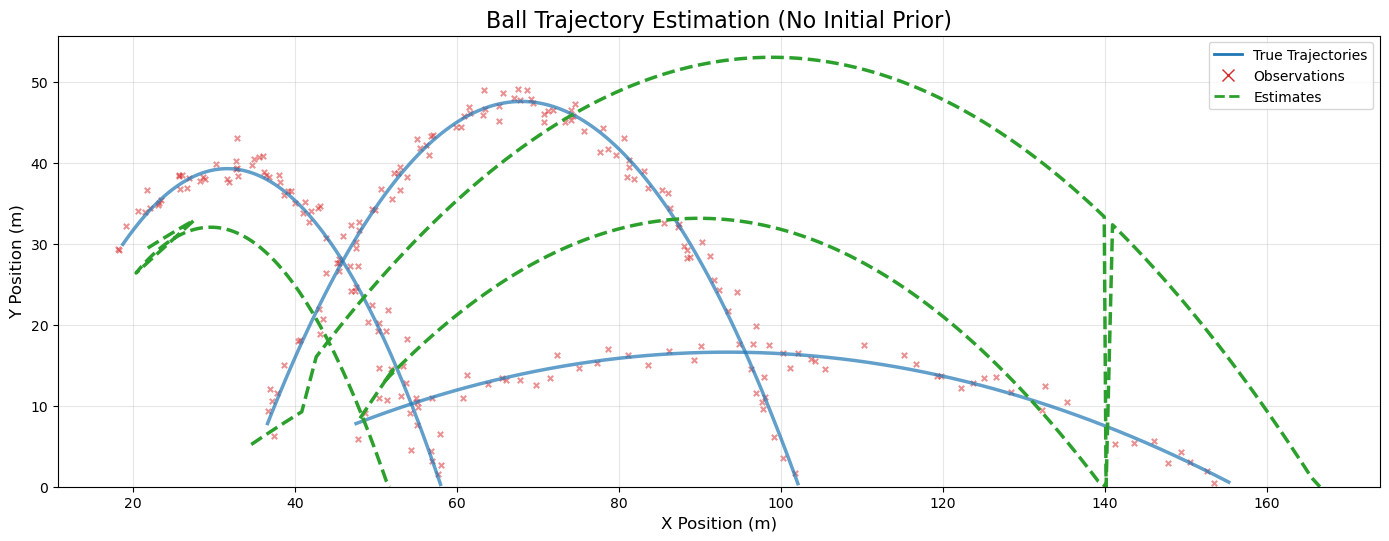

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import copy

# Parameters
g = 9.81
n_balls = 3
n_particles = 8000
observation_noise_std = 1.0
p_detect = 0.85
dt = 0.05
T = 10
t = np.arange(0, T, dt)

# True initial conditions
np.random.seed(42)
true_start_x = np.random.uniform(0, 50, n_balls)
true_start_y = np.random.uniform(0, 50, n_balls)
true_speeds = np.random.uniform(15, 40, n_balls)
true_angles_rad = np.deg2rad(np.random.uniform(20, 70, n_balls))

# Simulate true trajectories and noisy observations
true_trajectories = [[] for _ in range(n_balls)]
observations = []

for ti in t:
    current_obs = []
    for i in range(n_balls):
        x = true_start_x[i] + true_speeds[i] * np.cos(true_angles_rad[i]) * ti
        y = true_start_y[i] + true_speeds[i] * np.sin(true_angles_rad[i]) * ti - 0.5 * g * ti**2
        
        if y > 0:
            true_trajectories[i].append((ti, x, y))
            if np.random.rand() < p_detect:
                noisy_x = x + np.random.normal(0, observation_noise_std)
                noisy_y = y + np.random.normal(0, observation_noise_std)
                current_obs.append([noisy_x, noisy_y])
    
    observations.append(current_obs)

# Particle Filter Implementation =============================================

class Particle:
    def __init__(self, state):
        self.state = state  # [x1, y1, vx1, vy1, x2, y2, vx2, vy2, ...]
        self.landed = [False] * n_balls
        self.weight = 1.0
        self.log_weight = 0.0
    
    def predict(self, dt):
        new_state = self.state.copy()
        
        for i in range(n_balls):
            if not self.landed[i]:
                idx = 4*i
                x, y, vx, vy = self.state[idx:idx+4]
                
                # Simplified physics with only gravity
                new_x = x + vx * dt
                new_y = y + vy * dt - 0.5 * g * dt**2
                new_vy = vy - g * dt
                
                # Check for landing
                if new_y <= 0 and new_vy <= 0:
                    new_y = 0
                    new_vx = 0
                    new_vy = 0
                    self.landed[i] = True
                
                new_state[idx] = new_x
                new_state[idx+1] = new_y
                new_state[idx+2] = vx  # Velocity remains constant in x-direction
                new_state[idx+3] = new_vy
        
        self.state = new_state
    
    def get_positions(self):
        positions = []
        for i in range(n_balls):
            idx = 4*i
            positions.append(self.state[idx:idx+2])
        return positions
    
    def copy(self):
        new_particle = Particle(self.state.copy())
        new_particle.landed = self.landed.copy()
        new_particle.weight = self.weight
        new_particle.log_weight = self.log_weight
        return new_particle

# Initialize particles with UNKNOWN initial conditions
def initialize_particles(n_particles):
    particles = []
    for _ in range(n_particles):
        state = []
        ball_states = []
        for _ in range(n_balls):
            # Sample from plausible uniform distributions
            x = np.random.uniform(0, 50)           # X position range
            y = np.random.uniform(0, 50)           # Y position range
            speed = np.random.uniform(15, 40)       # Speed range
            angle = np.random.uniform(np.deg2rad(20), np.deg2rad(70))  # Angle range
            vx = speed * np.cos(angle)
            vy = speed * np.sin(angle)
            ball_states.append((x, y, vx, vy))
        np.random.shuffle(ball_states)
        for ball in ball_states:
            state.extend(ball)
        particles.append(Particle(np.array(state)))
    return particles

# Systematic resampling
def systematic_resample(weights, n_particles):
    positions = (np.arange(n_particles) + np.random.uniform(0, 1)) / n_particles
    cumulative = np.cumsum(weights)
    cumulative[-1] = 1.0
    return np.searchsorted(cumulative, positions)

# Log-likelihood calculation
def calculate_log_weight(particle, observations):
    pred_positions = particle.get_positions()
    active_pred = [pos for i, pos in enumerate(pred_positions) if not particle.landed[i]]
    k = len(active_pred)
    m = len(observations)
    
    if k == 0 and m == 0:
        return 0.0
    if m > k:
        return -np.inf
    
    cost_matrix = np.zeros((k, m))
    for i, pred in enumerate(active_pred):
        for j, obs in enumerate(observations):
            cost_matrix[i, j] = (pred[0] - obs[0])**2 + (pred[1] - obs[1])**2
    
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    log_weight = 0.0
    for i, j in zip(row_ind, col_ind):
        d_squared = cost_matrix[i, j]
        log_weight += -d_squared/(2*observation_noise_std**2) - np.log(2*np.pi*observation_noise_std**2)
    
    log_weight += m * np.log(p_detect)
    log_weight += (k - m) * np.log(1 - p_detect)
    
    return log_weight

# Adaptive regularization
def add_adaptive_regularization(particles, effective_n):
    all_states = np.array([p.state for p in particles])
    cov_matrix = np.cov(all_states, rowvar=False)
    
    for particle in particles:
        noise = np.random.multivariate_normal(
            mean=np.zeros_like(particle.state),
            cov=cov_matrix * (0.1 / effective_n)
        )
        for i in range(n_balls):
            if not particle.landed[i]:
                idx = 4*i
                particle.state[idx:idx+4] += noise[idx:idx+4]
    return particles

# Sort particles by x-position
def sort_particle_state(particle):
    ball_states = []
    for i in range(n_balls):
        idx = 4*i
        ball_states.append({
            'state': particle.state[idx:idx+4],
            'landed': particle.landed[i]
        })
    ball_states_sorted = sorted(ball_states, key=lambda b: b['state'][0])
    new_state = []
    new_landed = []
    for ball in ball_states_sorted:
        new_state.extend(ball['state'])
        new_landed.append(ball['landed'])
    particle.state = np.array(new_state)
    particle.landed = new_landed
    return particle

# Main Particle Filter ======================================================

particles = initialize_particles(n_particles)
estimated_trajectories = [[] for _ in range(n_balls)]

for time_idx, ti in enumerate(t):
    # Prediction step
    for particle in particles:
        particle.predict(dt)
    
    # Weight update
    current_obs = observations[time_idx]
    log_weights = np.zeros(n_particles)
    
    # Always calculate log weights (even when no observations)
    for i, particle in enumerate(particles):
        log_weights[i] = calculate_log_weight(particle, current_obs)
    
    # Replace -inf with large negative number to avoid NaN during subtraction
    log_weights = np.where(np.isneginf(log_weights), -1e20, log_weights)
    
    # Check if all weights are invalid
    if np.max(log_weights) == -1e20:
        weights = np.ones(n_particles) / n_particles
    else:
        # Normalize log weights safely
        max_log_weight = np.max(log_weights)
        log_weights -= max_log_weight
        weights = np.exp(log_weights)
        weight_sum = np.sum(weights)
        if weight_sum > 1e-10:
            weights /= weight_sum
        else:
            weights = np.ones(n_particles) / n_particles
    
    for i, particle in enumerate(particles):
        particle.weight = weights[i]
    
    # Resampling
    n_eff = 1.0 / np.sum(weights**2)
    if n_eff < n_particles * 0.4:
        indices = systematic_resample(weights, n_particles)
        particles = [particles[i].copy() for i in indices]
        particles = add_adaptive_regularization(particles, n_eff)
    
    # State estimation
    particles = [sort_particle_state(p) for p in particles]
    all_states = np.array([p.state for p in particles])
    mean_state = np.mean(all_states, axis=0)
    
    for i in range(n_balls):
        idx = 4*i
        x_est, y_est = mean_state[idx], mean_state[idx+1]
        estimated_trajectories[i].append([ti, x_est, y_est])

# Visualization =============================================================

plt.figure(figsize=(14, 10))

# Color scheme
true_color = '#1f77b4'  # Blue
obs_color = '#d62728'   # Red
est_color = '#2ca02c'   # Green

# Plot true trajectories
for i in range(n_balls):
    traj = np.array(true_trajectories[i])
    if len(traj) > 0:
        plt.plot(traj[:, 1], traj[:, 2], color=true_color, lw=2.5, alpha=0.7)

# Plot noisy observations
all_obs = np.concatenate([np.array(obs) for obs in observations if obs])
plt.scatter(all_obs[:, 0], all_obs[:, 1], color=obs_color, marker='x', 
           alpha=0.5, s=15, label='Observations')

# Plot estimated trajectories
for i in range(n_balls):
    est_traj = np.array([point[1:] for point in estimated_trajectories[i]])
    if len(est_traj) > 0:
        plt.plot(est_traj[:, 0], est_traj[:, 1], '--', color=est_color, lw=2.5)

# Plot configuration
plt.title("Ball Trajectory Estimation (No Initial Prior)", fontsize=16)
plt.xlabel("X Position (m)", fontsize=12)
plt.ylabel("Y Position (m)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(bottom=0)
plt.gca().set_aspect('equal', adjustable='box')

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=true_color, lw=2, label='True Trajectories'),
    Line2D([0], [0], marker='x', color=obs_color, lw=0, label='Observations', markersize=8),
    Line2D([0], [0], linestyle='--', color=est_color, lw=2, label='Estimates')
]
plt.legend(handles=legend_elements, fontsize=10, loc='upper right')

plt.tight_layout()
plt.show()

In [33]:
#The final Particle Filter implementation (Single partical filter for each ball )

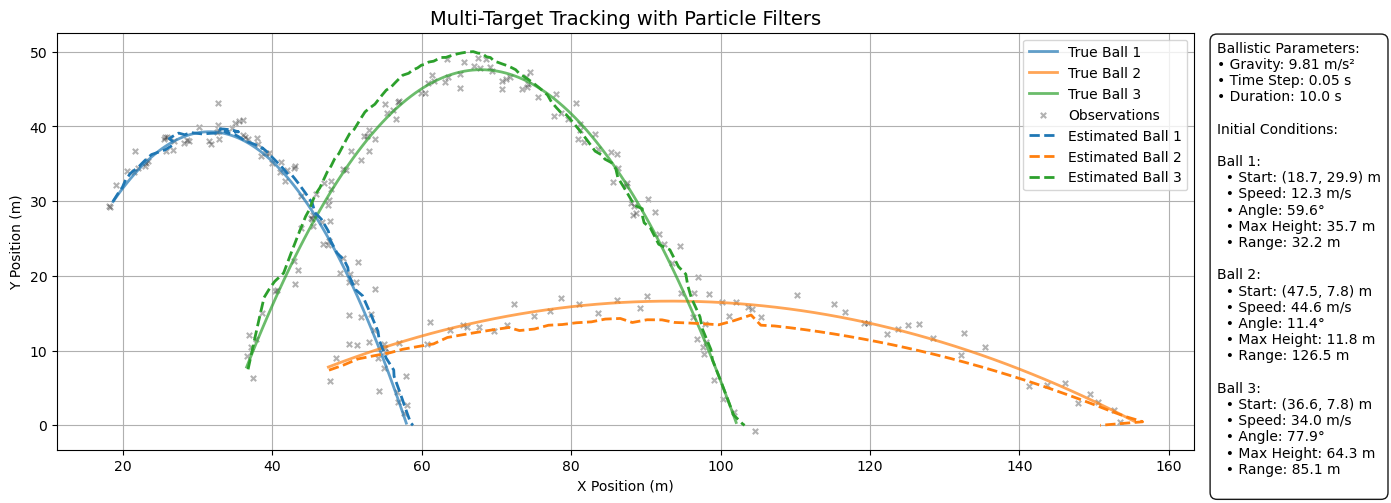

In [34]:
import copy
from scipy.optimize import linear_sum_assignment

n_particles_per_ball = 200
class Particle:
    def __init__(self, init_x, init_y, init_vx, init_vy):
        self.x = init_x
        self.y = init_y
        self.vx = init_vx
        self.vy = init_vy
        self.landed = False
        self.weight = 1.0

    def predict(self, dt):
        if self.landed:
            return
        self.x += self.vx * dt
        self.y += self.vy * dt - 0.5 * g * dt**2
        self.vy -= g * dt
        if self.y <= 0 and self.vy <= 0:
            self.y = 0
            self.vy = 0
            self.landed = True

    def as_vector(self):
        return np.array([self.x, self.y])
    
    def copy(self):
        p = Particle(self.x, self.y, self.vx, self.vy)
        p.landed = self.landed
        p.weight = self.weight
        return p

# Initialize particle filters
initial_pos_noise_std = 0.5
initial_vel_noise_std = 2.0
PFs = []
for i in range(n_balls):
    particles = []
    vx = speeds[i] * np.cos(angles_rad[i])
    vy = speeds[i] * np.sin(angles_rad[i])
    
    for _ in range(n_particles_per_ball):
        p = Particle(
            init_x=np.random.normal(start_x[i], initial_pos_noise_std),
            init_y=np.random.normal(start_y[i], initial_pos_noise_std),
            init_vx=np.random.normal(vx, initial_vel_noise_std),
            init_vy=np.random.normal(vy, initial_vel_noise_std)
        )
        particles.append(p)
    PFs.append(particles)

# Stratified resampling function
def stratified_resample(weights, n_particles):
    positions = (np.arange(n_particles) + np.random.random(n_particles)) / n_particles
    cumulative = np.cumsum(weights)
    cumulative[-1] = 1.0
    return np.searchsorted(cumulative, positions)

# Track estimation history
estimated_trajectories = [[] for _ in range(n_balls)]
particle_frames = []
mean_frames = []

# Time 0 initialization
meas0 = np.array(observations[0])
means0 = []
for pf in PFs:
    x_mean = np.mean([p.x for p in pf])
    y_mean = np.mean([p.y for p in pf])
    means0.append([x_mean, y_mean])
means0 = np.array(means0)

# Measurement assignment
cost_matrix = np.zeros((n_balls, len(meas0)))
for i in range(n_balls):
    for j in range(len(meas0)):
        cost_matrix[i, j] = np.linalg.norm(means0[i] - meas0[j])
_, col_ind = linear_sum_assignment(cost_matrix)

# Update weights
for i in range(n_balls):
    pf = PFs[i]
    assigned_meas = meas0[col_ind[i]]
    for p in pf:
        dist = np.linalg.norm(p.as_vector() - assigned_meas)
        p.weight = np.exp(-dist**2 / (2 * observation_noise_std**2))
    
    weights = np.array([p.weight for p in pf])
    weights_sum = weights.sum()
    if weights_sum < 1e-10:
        weights = np.ones(n_particles_per_ball) / n_particles_per_ball
    else:
        weights /= weights_sum
    
    # Adaptive resampling with regularization
    n_eff = 1.0 / (weights**2).sum()
    if n_eff < n_particles_per_ball * 0.7:  # Higher threshold
        indices = stratified_resample(weights, n_particles_per_ball)
        new_particles = [pf[idx].copy() for idx in indices]
        
        # Add regularization noise
        for p in new_particles:
            if not p.landed:
                p.x += np.random.normal(0, 0.1 * observation_noise_std)
                p.y += np.random.normal(0, 0.1 * observation_noise_std)
                p.vx += np.random.normal(0, 0.1 * initial_vel_noise_std)
                p.vy += np.random.normal(0, 0.1 * initial_vel_noise_std)
            else:
                p.x += np.random.normal(0, 0.05 * observation_noise_std)
        
        PFs[i] = new_particles
    else:
        for idx, p in enumerate(pf):
            p.weight = weights[idx]

# Record initial state
for i in range(n_balls):
    pf = PFs[i]
    x_mean = np.mean([p.x for p in pf])
    y_mean = np.mean([p.y for p in pf])
    estimated_trajectories[i].append([t[0], x_mean, y_mean])

# Main particle filter loop
for time_idx in range(len(t)-1):
    # Predict next state
    for pf in PFs:
        for p in pf:
            p.predict(dt)
    
    # Get next measurement
    meas_next = np.array(observations[time_idx+1]) if time_idx+1 < len(observations) else np.empty((0,2))
    
    # Compute predicted means
    means_prior = []
    for pf in PFs:
        x_mean = np.mean([p.x for p in pf])
        y_mean = np.mean([p.y for p in pf])
        means_prior.append([x_mean, y_mean])
    means_prior = np.array(means_prior)
    
    # Measurement assignment (if observations available)
    if len(meas_next) > 0:
        active_idxs = [i for i in range(n_balls) if not all(p.landed for p in PFs[i])]
        if len(active_idxs) > 0 and len(meas_next) >= len(active_idxs):
            cost_matrix = np.zeros((len(active_idxs), len(meas_next)))
            for i_idx, i in enumerate(active_idxs):
                for j in range(len(meas_next)):
                    cost_matrix[i_idx, j] = np.linalg.norm(means_prior[i] - meas_next[j])
            row_ind, col_ind = linear_sum_assignment(cost_matrix)
            assignment_map = {active_idxs[row_ind[i]]: col_ind[i] for i in range(len(row_ind))}
        else:
            assignment_map = {}
    else:
        assignment_map = {}

    
    frame_particles = []
    frame_means = []
    
    # Update each particle filter
    for i in range(n_balls):
        pf = PFs[i]
        
        # Only update if observations available and ball not landed
        if i in assignment_map:
            assigned_meas = meas_next[assignment_map[i]]
            
            # Update weights
            for p in pf:
                dist = np.linalg.norm(p.as_vector() - assigned_meas)
                p.weight = np.exp(-dist**2 / (2 * observation_noise_std**2))
            
            weights = np.array([p.weight for p in pf])
            weights_sum = weights.sum()
            if weights_sum < 1e-10:
                weights = np.ones(n_particles_per_ball) / n_particles_per_ball
            else:
                weights /= weights_sum
            
            # Adaptive resampling with regularization
            n_eff = 1.0 / (weights**2).sum()
            if n_eff < n_particles_per_ball * 0.7:
                indices = stratified_resample(weights, n_particles_per_ball)
                new_particles = [pf[idx].copy() for idx in indices]
                
                # Add regularization noise
                for p in new_particles:
                    if not p.landed:
                        p.x += np.random.normal(0, 0.1 * observation_noise_std)
                        p.y += np.random.normal(0, 0.1 * observation_noise_std)
                        p.vx += np.random.normal(0, 0.1 * initial_vel_noise_std)
                        p.vy += np.random.normal(0, 0.1 * initial_vel_noise_std)
                    else:
                        p.x += np.random.normal(0, 0.05 * observation_noise_std)
                
                PFs[i] = new_particles
            else:
                for idx, p in enumerate(pf):
                    p.weight = weights[idx]
        
        # Record state
        frame_particles.append(np.array([p.as_vector() for p in PFs[i]]))
        x_mean = np.mean([p.x for p in PFs[i]])
        y_mean = np.mean([p.y for p in PFs[i]])
        frame_means.append([x_mean, y_mean])
        estimated_trajectories[i].append([t[time_idx+1], x_mean, y_mean])
    
    particle_frames.append(frame_particles)
    mean_frames.append(frame_means)

plt.figure(figsize=(14, 8))

# Plot true trajectories
for i in range(n_balls):
    traj = np.array(true_trajectories[i])
    if len(traj) > 0:
        if traj.shape[1] == 3:
            plt.plot(traj[:, 1], traj[:, 2], 
                     label=f'True Ball {i+1}', color=colors(i), lw=2, alpha=0.7)
        elif traj.shape[1] == 2:
            plt.plot(traj[:, 0], traj[:, 1], 
                     label=f'True Ball {i+1}', color=colors(i), lw=2, alpha=0.7)

# Plot noisy observations
all_obs = np.concatenate([np.array(obs) for obs in observations if obs])
plt.scatter(all_obs[:, 0], all_obs[:, 1], color='black', marker='x', 
            alpha=0.3, s=15, label='Observations')

# Plot estimated trajectories
for i in range(n_balls):
    est_traj = np.array([point[1:] for point in estimated_trajectories[i] if len(point) > 1])
    if len(est_traj) > 0:
        plt.plot(est_traj[:, 0], est_traj[:, 1], '--', 
                 label=f'Estimated Ball {i+1}', color=colors(i), lw=2)

# Ballistic parameters info box content
info_text = (
    f"Ballistic Parameters:\n"
    f"• Gravity: {g:.2f} m/s²\n"
    f"• Time Step: {dt:.2f} s\n"
    f"• Duration: {T:.1f} s\n\n"
    f"Initial Conditions:\n"
)
for i in range(n_balls):
    max_height = start_y[i] + (speeds[i] * np.sin(angles_rad[i]))**2 / (2 * g)
    range_est = start_x[i] + (speeds[i]**2 * np.sin(2 * angles_rad[i])) / g
    info_text += (
        f"\nBall {i+1}:\n"
        f"  • Start: ({start_x[i]:.1f}, {start_y[i]:.1f}) m\n"
        f"  • Speed: {speeds[i]:.1f} m/s\n"
        f"  • Angle: {angles_deg[i]:.1f}°\n"
        f"  • Max Height: {max_height:.1f} m\n"
        f"  • Range: {range_est:.1f} m\n"
    )

plt.gca().text(1.02, 0.98, info_text, transform=plt.gca().transAxes,
               fontsize=10, va='top', ha='left',
               bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.9))

plt.title("Multi-Target Tracking with Particle Filters", fontsize=14)
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.legend(loc='upper right')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

In [35]:
# Variable dt for the same

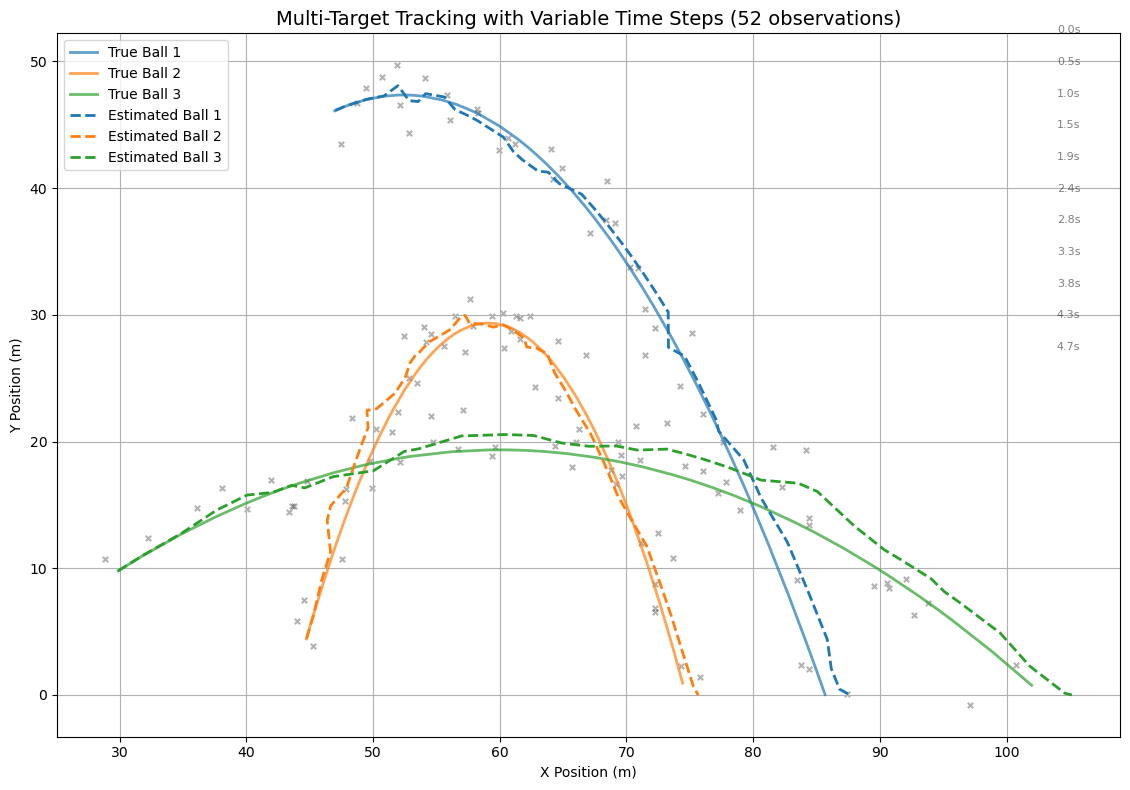

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.optimize import linear_sum_assignment
from matplotlib import colormaps
from scipy.stats import gaussian_kde
import copy

# Parameters
g = 9.81
n_balls = 3
n_particles_per_ball = 200
observation_noise_std = 1.5
T = 5
colors = colormaps["tab10"]

# Generate variable time steps with random intervals
np.random.seed(42)
min_dt = 0.05  # Minimum time step
max_dt = 0.15  # Maximum time step
t = [0.0]  # Start at time 0
while t[-1] < T:
    dt = np.random.uniform(min_dt, max_dt)
    new_time = t[-1] + dt
    if new_time >= T:
        break
    t.append(new_time)
t = np.array(t)

# Initial conditions
start_x = np.random.uniform(0, 50, n_balls)
start_y = np.random.uniform(0, 50, n_balls)
speeds = np.random.uniform(10, 50, n_balls)
angles_deg = np.random.uniform(1, 89, n_balls)
angles_rad = np.deg2rad(angles_deg)

# True trajectories and noisy observations (STOP when landed)
true_trajectories = [[] for _ in range(n_balls)]
observations = []

for ti in t:
    current_obs = []
    for i in range(n_balls):
        x = start_x[i] + speeds[i] * np.cos(angles_rad[i]) * ti
        y = start_y[i] + speeds[i] * np.sin(angles_rad[i]) * ti - 0.5 * g * ti**2
        if y > 0:  # Only generate observations while airborne
            true_trajectories[i].append((ti, x, y))
            noisy_x = x + np.random.normal(0, observation_noise_std)
            noisy_y = y + np.random.normal(0, observation_noise_std)
            current_obs.append([noisy_x, noisy_y])
    observations.append(current_obs)

# Particle class with copy method
class Particle:
    def __init__(self, init_x, init_y, init_vx, init_vy):
        self.x = init_x
        self.y = init_y
        self.vx = init_vx
        self.vy = init_vy
        self.landed = False
        self.weight = 1.0

    def predict(self, dt):
        if self.landed:
            return
        self.x += self.vx * dt
        self.y += self.vy * dt - 0.5 * g * dt**2
        self.vy -= g * dt
        if self.y <= 0 and self.vy <= 0:
            self.y = 0
            self.vy = 0
            self.landed = True

    def as_vector(self):
        return np.array([self.x, self.y])
    
    def copy(self):
        p = Particle(self.x, self.y, self.vx, self.vy)
        p.landed = self.landed
        p.weight = self.weight
        return p

# Initialize particle filters
initial_pos_noise_std = 0.5
initial_vel_noise_std = 2.0
PFs = []
for i in range(n_balls):
    particles = []
    vx = speeds[i] * np.cos(angles_rad[i])
    vy = speeds[i] * np.sin(angles_rad[i])
    
    for _ in range(n_particles_per_ball):
        p = Particle(
            init_x=np.random.normal(start_x[i], initial_pos_noise_std),
            init_y=np.random.normal(start_y[i], initial_pos_noise_std),
            init_vx=np.random.normal(vx, initial_vel_noise_std),
            init_vy=np.random.normal(vy, initial_vel_noise_std)
        )
        particles.append(p)
    PFs.append(particles)

# Stratified resampling function
def stratified_resample(weights, n_particles):
    positions = (np.arange(n_particles) + np.random.random(n_particles)) / n_particles
    cumulative = np.cumsum(weights)
    cumulative[-1] = 1.0
    return np.searchsorted(cumulative, positions)

# Track estimation history
estimated_trajectories = [[] for _ in range(n_balls)]
particle_frames = []
mean_frames = []

# Time 0 initialization
if observations[0]:  # Ensure we have observations at t=0
    meas0 = np.array(observations[0])
    means0 = []
    for pf in PFs:
        x_mean = np.mean([p.x for p in pf])
        y_mean = np.mean([p.y for p in pf])
        means0.append([x_mean, y_mean])
    means0 = np.array(means0)

    # Measurement assignment
    cost_matrix = np.zeros((n_balls, len(meas0)))
    for i in range(n_balls):
        for j in range(len(meas0)):
            cost_matrix[i, j] = np.linalg.norm(means0[i] - meas0[j])
    _, col_ind = linear_sum_assignment(cost_matrix)

    # Update weights
    for i in range(n_balls):
        pf = PFs[i]
        assigned_meas = meas0[col_ind[i]]
        for p in pf:
            dist = np.linalg.norm(p.as_vector() - assigned_meas)
            p.weight = np.exp(-dist**2 / (2 * observation_noise_std**2))
        
        weights = np.array([p.weight for p in pf])
        weights_sum = weights.sum()
        if weights_sum < 1e-10:
            weights = np.ones(n_particles_per_ball) / n_particles_per_ball
        else:
            weights /= weights_sum
        
        # Adaptive resampling with regularization
        n_eff = 1.0 / (weights**2).sum()
        if n_eff < n_particles_per_ball * 0.7:  # Higher threshold
            indices = stratified_resample(weights, n_particles_per_ball)
            new_particles = [pf[idx].copy() for idx in indices]
            
            # Add regularization noise
            for p in new_particles:
                if not p.landed:
                    p.x += np.random.normal(0, 0.1 * observation_noise_std)
                    p.y += np.random.normal(0, 0.1 * observation_noise_std)
                    p.vx += np.random.normal(0, 0.1 * initial_vel_noise_std)
                    p.vy += np.random.normal(0, 0.1 * initial_vel_noise_std)
                else:
                    p.x += np.random.normal(0, 0.05 * observation_noise_std)
            
            PFs[i] = new_particles
        else:
            for idx, p in enumerate(pf):
                p.weight = weights[idx]

# Record initial state
for i in range(n_balls):
    pf = PFs[i]
    x_mean = np.mean([p.x for p in pf])
    y_mean = np.mean([p.y for p in pf])
    estimated_trajectories[i].append([t[0], x_mean, y_mean])

# Main particle filter loop
for time_idx in range(len(t)-1):
    # Calculate current time step
    current_dt = t[time_idx+1] - t[time_idx]
    
    # Predict next state with variable dt
    for pf in PFs:
        for p in pf:
            p.predict(current_dt)
    
    # Get next measurement
    meas_next = np.array(observations[time_idx+1]) if time_idx+1 < len(observations) else np.empty((0,2))
    
    # Compute predicted means
    means_prior = []
    for pf in PFs:
        x_mean = np.mean([p.x for p in pf])
        y_mean = np.mean([p.y for p in pf])
        means_prior.append([x_mean, y_mean])
    means_prior = np.array(means_prior)
    
    # Measurement assignment (if observations available)
    if len(meas_next) > 0:
        active_idxs = [i for i in range(n_balls) if not all(p.landed for p in PFs[i])]
        if len(active_idxs) > 0 and len(meas_next) >= len(active_idxs):
            cost_matrix = np.zeros((len(active_idxs), len(meas_next)))
            for i_idx, i in enumerate(active_idxs):
                for j in range(len(meas_next)):
                    cost_matrix[i_idx, j] = np.linalg.norm(means_prior[i] - meas_next[j])
            row_ind, col_ind = linear_sum_assignment(cost_matrix)
            assignment_map = {active_idxs[row_ind[i]]: col_ind[i] for i in range(len(row_ind))}
        else:
            assignment_map = {}
    else:
        assignment_map = {}

    
    frame_particles = []
    frame_means = []
    
    # Update each particle filter
    for i in range(n_balls):
        pf = PFs[i]
        
        # Only update if observations available and ball not landed
        if i in assignment_map:
            assigned_meas = meas_next[assignment_map[i]]
            
            # Update weights
            for p in pf:
                dist = np.linalg.norm(p.as_vector() - assigned_meas)
                p.weight = np.exp(-dist**2 / (2 * observation_noise_std**2))
            
            weights = np.array([p.weight for p in pf])
            weights_sum = weights.sum()
            if weights_sum < 1e-10:
                weights = np.ones(n_particles_per_ball) / n_particles_per_ball
            else:
                weights /= weights_sum
            
            # Adaptive resampling with regularization
            n_eff = 1.0 / (weights**2).sum()
            if n_eff < n_particles_per_ball * 0.7:
                indices = stratified_resample(weights, n_particles_per_ball)
                new_particles = [pf[idx].copy() for idx in indices]
                
                # Add regularization noise
                for p in new_particles:
                    if not p.landed:
                        p.x += np.random.normal(0, 0.1 * observation_noise_std)
                        p.y += np.random.normal(0, 0.1 * observation_noise_std)
                        p.vx += np.random.normal(0, 0.1 * initial_vel_noise_std)
                        p.vy += np.random.normal(0, 0.1 * initial_vel_noise_std)
                    else:
                        p.x += np.random.normal(0, 0.05 * observation_noise_std)
                
                PFs[i] = new_particles
            else:
                for idx, p in enumerate(pf):
                    p.weight = weights[idx]
        
        # Record state
        frame_particles.append(np.array([p.as_vector() for p in PFs[i]]))
        x_mean = np.mean([p.x for p in PFs[i]])
        y_mean = np.mean([p.y for p in PFs[i]])
        frame_means.append([x_mean, y_mean])
        estimated_trajectories[i].append([t[time_idx+1], x_mean, y_mean])
    
    particle_frames.append(frame_particles)
    mean_frames.append(frame_means)

def plot_particle_filter_diagnostics(time_idx, ball_idx):
    """
    Plots 2D KDE, weights histogram, and scatter plot of particles for given time and ball.
    
    Parameters:
    - time_idx: int, index of time step to visualize (0-based)
    - ball_idx: int, which ball (0 to n_balls-1)
    """
    particles = particle_frames[time_idx][ball_idx]  # shape (n_particles, 2)
    weights = np.array([p.weight for p in PFs[ball_idx]])
    
    x = particles[:, 0]
    y = particles[:, 1]

    # 2D KDE plot
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, weights=weights)
    
    # Grid for KDE
    xmin, xmax = x.min() - 2, x.max() + 2
    ymin, ymax = y.min() - 2, y.max() + 2
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    density = kde(positions).reshape(xx.shape)
    
    plt.figure(figsize=(18, 5))
    
    # Plot KDE
    plt.subplot(1, 3, 1)
    plt.title(f"2D KDE of Particle Distribution\nBall {ball_idx+1}, Time {t[time_idx]:.2f}s")
    plt.imshow(np.rot90(density), cmap='viridis', extent=[xmin, xmax, ymin, ymax])
    plt.scatter(x, y, c='white', s=5, alpha=0.5)
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.colorbar(label='Density')
    
    # Plot weights histogram
    plt.subplot(1, 3, 2)
    plt.title("Particle Weights Histogram")
    plt.hist(weights, bins=30, color=colors(ball_idx), alpha=0.7)
    plt.xlabel("Weight")
    plt.ylabel("Count")
    
    # Plot particle scatter colored by weight
    plt.subplot(1, 3, 3)
    plt.title("Particle Cloud (Colored by Weight)")
    sc = plt.scatter(x, y, c=weights, cmap='plasma', s=20, edgecolor='k', alpha=0.8)
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.colorbar(sc, label='Weight')
    
    plt.tight_layout()
    plt.show()
        
# Visualization
plt.figure(figsize=(14, 8))

# Plot true trajectories
for i in range(n_balls):
    traj = np.array(true_trajectories[i])
    if len(traj) > 0:
        plt.plot(traj[:, 1], traj[:, 2], 
                label=f'True Ball {i+1}', color=colors(i), lw=2, alpha=0.7)

# Plot noisy observations with time information
for time_idx, obs in enumerate(observations):
    if obs:
        time_val = t[time_idx]
        for point in obs:
            plt.scatter(point[0], point[1], color='black', marker='x', s=15, alpha=0.3)

# Plot estimated trajectories
for i in range(n_balls):
    est_traj = np.array([point[1:] for point in estimated_trajectories[i] if len(point) > 1])
    if len(est_traj) > 0:
        plt.plot(est_traj[:, 0], est_traj[:, 1], '--', 
                label=f'Estimated Ball {i+1}', color=colors(i), lw=2)

# Add time annotation for variable intervals
for i, time_val in enumerate(t):
    if i % 5 == 0:  # Annotate every 5th time point to avoid clutter
        plt.annotate(f"{time_val:.1f}s", 
                    (plt.xlim()[1] - 5, plt.ylim()[1] - i*0.5), 
                    fontsize=8, alpha=0.5)

# Formatting
plt.title(f"Multi-Target Tracking with Variable Time Steps ({len(t)} observations)", fontsize=14)
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()


In [37]:
# Particle filter with DropOuts per ball w.r.t time

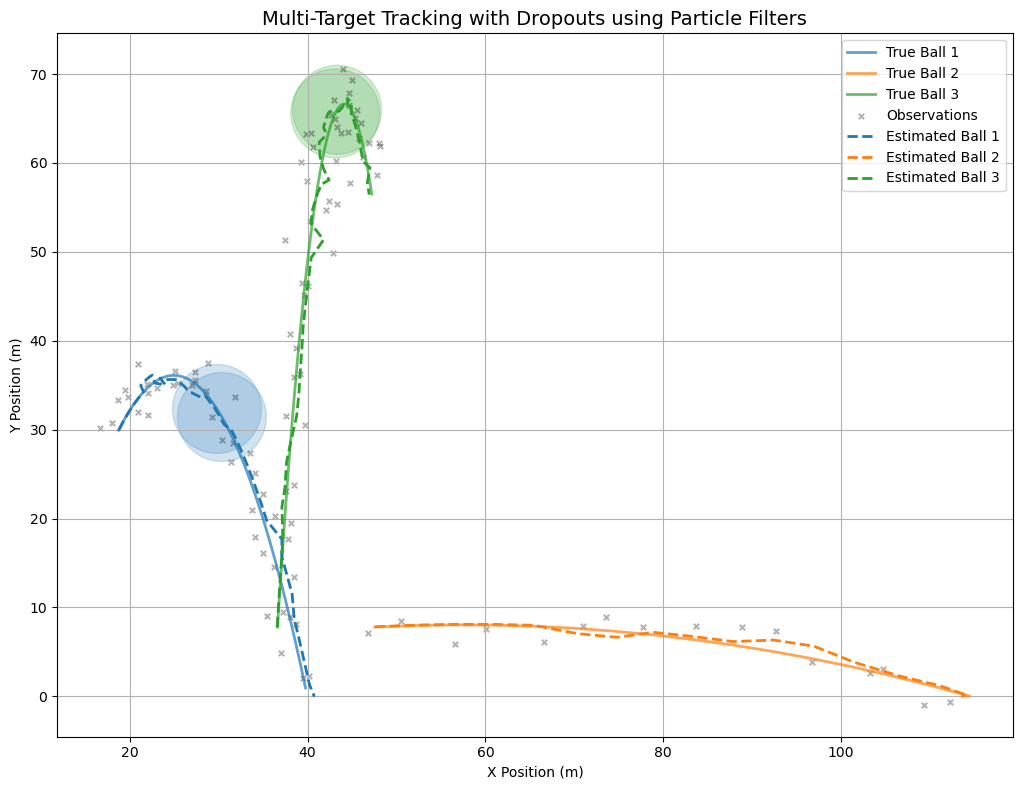

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.optimize import linear_sum_assignment
from matplotlib import colormaps
import copy

# Parameters
g = 9.81
n_balls = 3
n_particles_per_ball = 200
observation_noise_std = 1.5
dt = 0.1
T = 5
t = np.arange(0, T, dt)
colors = colormaps["tab10"]

# Initial conditions
np.random.seed(42)
start_x = np.random.uniform(0, 50, n_balls)
start_y = np.random.uniform(0, 50, n_balls)
speeds = np.random.uniform(10, 50, n_balls)
angles_deg = np.random.uniform(1, 89, n_balls)
angles_rad = np.deg2rad(angles_deg)

# Dropout regions (time indices when dropouts occur for each ball)
dropout_indices = {
    0: [20, 21],
    1: [25, 26],
    2: [30, 31]
}

# True trajectories and noisy observations (STOP when landed)
true_trajectories = [[] for _ in range(n_balls)]
observations = []

for ti_idx, ti in enumerate(t):
    current_obs = []
    for i in range(n_balls):
        x = start_x[i] + speeds[i] * np.cos(angles_rad[i]) * ti
        y = start_y[i] + speeds[i] * np.sin(angles_rad[i]) * ti - 0.5 * g * ti**2
        if y > 0:  # Only generate observations while airborne
            true_trajectories[i].append((ti, x, y))
            if ti_idx not in dropout_indices.get(i, []):
                noisy_x = x + np.random.normal(0, observation_noise_std)
                noisy_y = y + np.random.normal(0, observation_noise_std)
                current_obs.append([noisy_x, noisy_y])
    observations.append(current_obs)

class Particle:
    def __init__(self, init_x, init_y, init_vx, init_vy):
        self.x = init_x
        self.y = init_y
        self.vx = init_vx
        self.vy = init_vy
        self.landed = False
        self.weight = 1.0

    def predict(self, dt):
        if self.landed:
            return
        self.x += self.vx * dt
        self.y += self.vy * dt - 0.5 * g * dt**2
        self.vy -= g * dt
        if self.y <= 0 and self.vy <= 0:
            self.y = 0
            self.vy = 0
            self.landed = True

    def as_vector(self):
        return np.array([self.x, self.y])

    def copy(self):
        p = Particle(self.x, self.y, self.vx, self.vy)
        p.landed = self.landed
        p.weight = self.weight
        return p

# Initialize particle filters
initial_pos_noise_std = 0.5
initial_vel_noise_std = 2.0
PFs = []
for i in range(n_balls):
    particles = []
    vx = speeds[i] * np.cos(angles_rad[i])
    vy = speeds[i] * np.sin(angles_rad[i])
    for _ in range(n_particles_per_ball):
        p = Particle(
            init_x=np.random.normal(start_x[i], initial_pos_noise_std),
            init_y=np.random.normal(start_y[i], initial_pos_noise_std),
            init_vx=np.random.normal(vx, initial_vel_noise_std),
            init_vy=np.random.normal(vy, initial_vel_noise_std)
        )
        particles.append(p)
    PFs.append(particles)

def stratified_resample(weights, n_particles):
    positions = (np.arange(n_particles) + np.random.random(n_particles)) / n_particles
    cumulative = np.cumsum(weights)
    cumulative[-1] = 1.0
    return np.searchsorted(cumulative, positions)

estimated_trajectories = [[] for _ in range(n_balls)]

# Time 0 initialization
meas0 = np.array(observations[0])
means0 = []
for pf in PFs:
    x_mean = np.mean([p.x for p in pf])
    y_mean = np.mean([p.y for p in pf])
    means0.append([x_mean, y_mean])
means0 = np.array(means0)

cost_matrix = np.zeros((n_balls, len(meas0)))
for i in range(n_balls):
    for j in range(len(meas0)):
        cost_matrix[i, j] = np.linalg.norm(means0[i] - meas0[j])
_, col_ind = linear_sum_assignment(cost_matrix)

for i in range(n_balls):
    pf = PFs[i]
    if i < len(col_ind):
        assigned_meas = meas0[col_ind[i]]
        for p in pf:
            dist = np.linalg.norm(p.as_vector() - assigned_meas)
            p.weight = np.exp(-dist**2 / (2 * observation_noise_std**2))
        weights = np.array([p.weight for p in pf])
        weights_sum = weights.sum()
        if weights_sum < 1e-10:
            weights = np.ones(n_particles_per_ball) / n_particles_per_ball
        else:
            weights /= weights_sum
        n_eff = 1.0 / (weights**2).sum()
        if n_eff < n_particles_per_ball * 0.7:
            indices = stratified_resample(weights, n_particles_per_ball)
            new_particles = [pf[idx].copy() for idx in indices]
            for p in new_particles:
                if not p.landed:
                    p.x += np.random.normal(0, 0.1 * observation_noise_std)
                    p.y += np.random.normal(0, 0.1 * observation_noise_std)
                    p.vx += np.random.normal(0, 0.1 * initial_vel_noise_std)
                    p.vy += np.random.normal(0, 0.1 * initial_vel_noise_std)
            PFs[i] = new_particles
        else:
            for idx, p in enumerate(pf):
                p.weight = weights[idx]
    x_mean = np.mean([p.x for p in pf])
    y_mean = np.mean([p.y for p in pf])
    estimated_trajectories[i].append([t[0], x_mean, y_mean])

# Main loop
for time_idx in range(1, len(t)):
    for pf in PFs:
        for p in pf:
            p.predict(dt)
    meas_next = np.array(observations[time_idx]) if time_idx < len(observations) else np.empty((0,2))
    means_prior = []
    for pf in PFs:
        x_mean = np.mean([p.x for p in pf])
        y_mean = np.mean([p.y for p in pf])
        means_prior.append([x_mean, y_mean])
    means_prior = np.array(means_prior)

    active_idxs = [i for i in range(n_balls) if not all(p.landed for p in PFs[i])]
    if len(meas_next) > 0 and len(active_idxs) > 0:
        cost_matrix = np.zeros((len(active_idxs), len(meas_next)))
        for i_idx, i in enumerate(active_idxs):
            for j in range(len(meas_next)):
                cost_matrix[i_idx, j] = np.linalg.norm(means_prior[i] - meas_next[j])
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        assignment_map = {active_idxs[row_ind[i]]: col_ind[i] for i in range(len(row_ind))}
    else:
        assignment_map = {}

    for i in range(n_balls):
        pf = PFs[i]
        if time_idx not in dropout_indices.get(i, []) and i in assignment_map:
            assigned_meas = meas_next[assignment_map[i]]
            for p in pf:
                dist = np.linalg.norm(p.as_vector() - assigned_meas)
                p.weight = np.exp(-dist**2 / (2 * observation_noise_std**2))
            weights = np.array([p.weight for p in pf])
            weights_sum = weights.sum()
            if weights_sum < 1e-10:
                weights = np.ones(n_particles_per_ball) / n_particles_per_ball
            else:
                weights /= weights_sum
            n_eff = 1.0 / (weights**2).sum()
            if n_eff < n_particles_per_ball * 0.7:
                indices = stratified_resample(weights, n_particles_per_ball)
                new_particles = [pf[idx].copy() for idx in indices]
                for p in new_particles:
                    if not p.landed:
                        p.x += np.random.normal(0, 0.1 * observation_noise_std)
                        p.y += np.random.normal(0, 0.1 * observation_noise_std)
                        p.vx += np.random.normal(0, 0.1 * initial_vel_noise_std)
                        p.vy += np.random.normal(0, 0.1 * initial_vel_noise_std)
                PFs[i] = new_particles
            else:
                for idx, p in enumerate(pf):
                    p.weight = weights[idx]
        x_mean = np.mean([p.x for p in pf])
        y_mean = np.mean([p.y for p in pf])
        estimated_trajectories[i].append([t[time_idx], x_mean, y_mean])

# Visualization
plt.figure(figsize=(14, 8))

for i in range(n_balls):
    traj = np.array(true_trajectories[i])
    if len(traj) > 0:
        plt.plot(traj[:, 1], traj[:, 2], label=f'True Ball {i+1}', color=colors(i), lw=2, alpha=0.7)
        for drop_idx in dropout_indices[i]:
            if drop_idx < len(traj):
                center_x, center_y = traj[drop_idx][1], traj[drop_idx][2]
                circ = plt.Circle((center_x, center_y), 5.0, color=colors(i), alpha=0.2)
                plt.gca().add_patch(circ)

all_obs = np.concatenate([np.array(obs) for obs in observations if obs])
plt.scatter(all_obs[:, 0], all_obs[:, 1], color='black', marker='x', alpha=0.3, s=15, label='Observations')

for i in range(n_balls):
    est_traj = np.array([point[1:] for point in estimated_trajectories[i] if len(point) > 1])
    if len(est_traj) > 0:
        plt.plot(est_traj[:, 0], est_traj[:, 1], '--', label=f'Estimated Ball {i+1}', color=colors(i), lw=2)

plt.title("Multi-Target Tracking with Dropouts using Particle Filters", fontsize=14)
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()


In [39]:
# Particle filter with Global Drop outs in the scanner(all balls simultaneously)

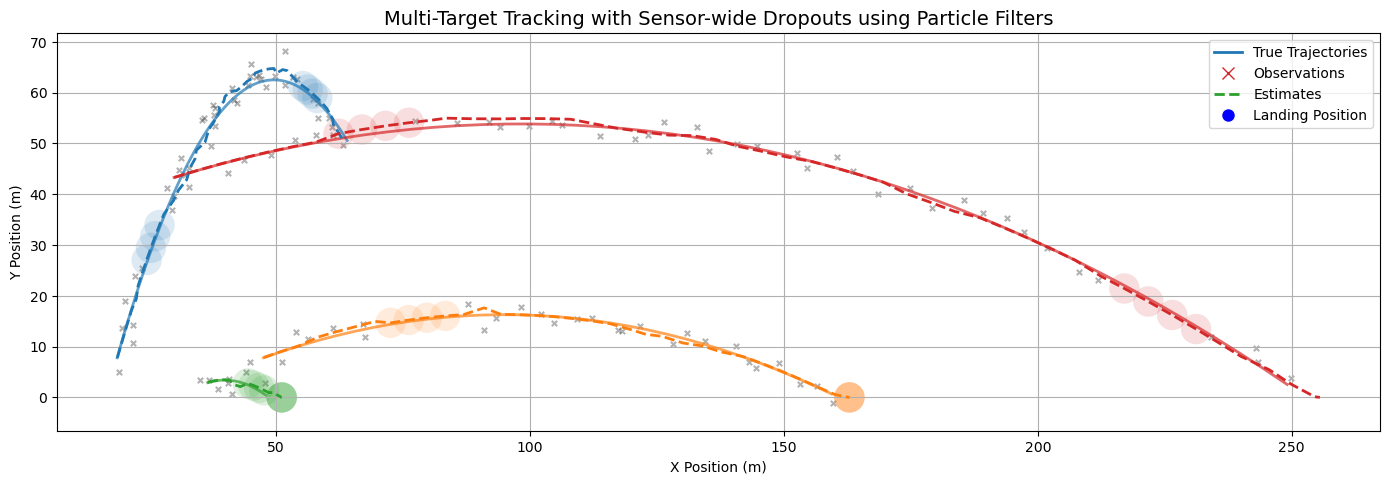

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.optimize import linear_sum_assignment
from matplotlib import colormaps
import copy
import random

# Parameters
g = 9.81
n_balls = 4
n_particles_per_ball = 200
observation_noise_std = 1.5
dt = 0.1
T = 5
t = np.arange(0, T, dt)
colors = colormaps["tab10"]

np.random.seed(42)
random.seed(42)

start_x = np.random.uniform(0, 50, n_balls)
start_y = np.random.uniform(0, 50, n_balls)
speeds = np.random.uniform(10, 50, n_balls)
angles_deg = np.random.uniform(1, 89, n_balls)
angles_rad = np.deg2rad(angles_deg)

# -------------
# Generate sensor-wide dropout intervals (randomized)
dropout_length = 4
max_dropout_start = len(t) - dropout_length - 1

dropout_intervals = []
num_dropouts = 2  # total number of dropout intervals
for _ in range(num_dropouts):
    start = random.randint(0, max_dropout_start)
    dropout_intervals.append(range(start, start + dropout_length))

def is_sensor_dropout(ti_idx):
    return any(ti_idx in interval for interval in dropout_intervals)
# -------------

# Generate true trajectories and noisy observations (omit noise during sensor dropout)
true_trajectories = [[] for _ in range(n_balls)]
observations = []

for ti_idx, ti in enumerate(t):
    current_obs = []
    for i in range(n_balls):
        x = start_x[i] + speeds[i] * np.cos(angles_rad[i]) * ti
        y = start_y[i] + speeds[i] * np.sin(angles_rad[i]) * ti - 0.5 * g * ti**2
        if y > 0:
            true_trajectories[i].append((ti, x, y))
            if not is_sensor_dropout(ti_idx):
                noisy_x = x + np.random.normal(0, observation_noise_std)
                noisy_y = y + np.random.normal(0, observation_noise_std)
                current_obs.append([noisy_x, noisy_y])
    observations.append(current_obs)

class Particle:
    def __init__(self, init_x, init_y, init_vx, init_vy):
        self.x = init_x
        self.y = init_y
        self.vx = init_vx
        self.vy = init_vy
        self.landed = False
        self.weight = 1.0

    def predict(self, dt):
        if self.landed:
            return
        self.x += self.vx * dt
        self.y += self.vy * dt - 0.5 * g * dt**2
        self.vy -= g * dt
        if self.y <= 0 and self.vy <= 0:
            self.y = 0
            self.vy = 0
            self.landed = True

    def as_vector(self):
        return np.array([self.x, self.y])

    def copy(self):
        p = Particle(self.x, self.y, self.vx, self.vy)
        p.landed = self.landed
        p.weight = self.weight
        return p

initial_pos_noise_std = 0.5
initial_vel_noise_std = 2.0
PFs = []
for i in range(n_balls):
    particles = []
    vx = speeds[i] * np.cos(angles_rad[i])
    vy = speeds[i] * np.sin(angles_rad[i])
    for _ in range(n_particles_per_ball):
        p = Particle(
            init_x=np.random.normal(start_x[i], initial_pos_noise_std),
            init_y=np.random.normal(start_y[i], initial_pos_noise_std),
            init_vx=np.random.normal(vx, initial_vel_noise_std),
            init_vy=np.random.normal(vy, initial_vel_noise_std)
        )
        particles.append(p)
    PFs.append(particles)

def stratified_resample(weights, n_particles):
    positions = (np.arange(n_particles) + np.random.random(n_particles)) / n_particles
    cumulative = np.cumsum(weights)
    cumulative[-1] = 1.0
    return np.searchsorted(cumulative, positions)

estimated_trajectories = [[] for _ in range(n_balls)]

# Initial assignment and update (at t=0, assuming no dropout at t=0)
meas0 = np.array(observations[0])
means0 = []
for pf in PFs:
    x_mean = np.mean([p.x for p in pf])
    y_mean = np.mean([p.y for p in pf])
    means0.append([x_mean, y_mean])
means0 = np.array(means0)

cost_matrix = np.zeros((n_balls, len(meas0)))
for i in range(n_balls):
    for j in range(len(meas0)):
        cost_matrix[i, j] = np.linalg.norm(means0[i] - meas0[j])
_, col_ind = linear_sum_assignment(cost_matrix)

for i in range(n_balls):
    pf = PFs[i]
    if i < len(col_ind):
        assigned_meas = meas0[col_ind[i]]
        for p in pf:
            dist = np.linalg.norm(p.as_vector() - assigned_meas)
            p.weight = np.exp(-dist**2 / (2 * observation_noise_std**2))
        weights = np.array([p.weight for p in pf])
        weights_sum = weights.sum()
        weights = weights / weights_sum if weights_sum > 1e-10 else np.ones(n_particles_per_ball) / n_particles_per_ball
        n_eff = 1.0 / (weights**2).sum()
        if n_eff < n_particles_per_ball * 0.7:
            indices = stratified_resample(weights, n_particles_per_ball)
            new_particles = [pf[idx].copy() for idx in indices]
            for p in new_particles:
                if not p.landed:
                    p.x += np.random.normal(0, 0.1 * observation_noise_std)
                    p.y += np.random.normal(0, 0.1 * observation_noise_std)
                    p.vx += np.random.normal(0, 0.1 * initial_vel_noise_std)
                    p.vy += np.random.normal(0, 0.1 * initial_vel_noise_std)
            PFs[i] = new_particles
        else:
            for idx, p in enumerate(pf):
                p.weight = weights[idx]
    x_mean = np.mean([p.x for p in pf])
    y_mean = np.mean([p.y for p in pf])
    estimated_trajectories[i].append([t[0], x_mean, y_mean])

for time_idx in range(1, len(t)):
    # Predict step for all particles
    for pf in PFs:
        for p in pf:
            p.predict(dt)

    if is_sensor_dropout(time_idx):
        # During sensor dropout: skip measurement update and resampling
        for i in range(n_balls):
            pf = PFs[i]
            x_mean = np.mean([p.x for p in pf])
            y_mean = np.mean([p.y for p in pf])
            estimated_trajectories[i].append([t[time_idx], x_mean, y_mean])
        continue

    # Not dropout: use observations to update particles
    meas_next = np.array(observations[time_idx]) if time_idx < len(observations) else np.empty((0, 2))
    means_prior = [np.mean([[p.x, p.y] for p in pf], axis=0) for pf in PFs]

    # Assign observations to balls by Hungarian algorithm
    active_idxs = [i for i in range(n_balls) if not all(p.landed for p in PFs[i])]
    assignment_map = {}
    if len(meas_next) > 0 and len(active_idxs) > 0:
        cost_matrix = np.zeros((len(active_idxs), len(meas_next)))
        for i_idx, i in enumerate(active_idxs):
            for j in range(len(meas_next)):
                cost_matrix[i_idx, j] = np.linalg.norm(means_prior[i] - meas_next[j])
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        assignment_map = {active_idxs[row_ind[i]]: col_ind[i] for i in range(len(row_ind))}

    for i in range(n_balls):
        pf = PFs[i]
        if i in assignment_map:
            assigned_meas = meas_next[assignment_map[i]]
            for p in pf:
                dist = np.linalg.norm(p.as_vector() - assigned_meas)
                p.weight = np.exp(-dist**2 / (2 * observation_noise_std**2))
            weights = np.array([p.weight for p in pf])
            weights_sum = weights.sum()
            weights = weights / weights_sum if weights_sum > 1e-10 else np.ones(n_particles_per_ball) / n_particles_per_ball
            n_eff = 1.0 / (weights**2).sum()
            if n_eff < n_particles_per_ball * 0.7:
                indices = stratified_resample(weights, n_particles_per_ball)
                new_particles = [pf[idx].copy() for idx in indices]
                for p in new_particles:
                    if not p.landed:
                        p.x += np.random.normal(0, 0.1 * observation_noise_std)
                        p.y += np.random.normal(0, 0.1 * observation_noise_std)
                        p.vx += np.random.normal(0, 0.1 * initial_vel_noise_std)
                        p.vy += np.random.normal(0, 0.1 * initial_vel_noise_std)
                PFs[i] = new_particles
            else:
                for idx, p in enumerate(pf):
                    p.weight = weights[idx]
        x_mean = np.mean([p.x for p in pf])
        y_mean = np.mean([p.y for p in pf])
        estimated_trajectories[i].append([t[time_idx], x_mean, y_mean])

# Plotting
plt.figure(figsize=(14, 8))

# Plot true trajectories
for i in range(n_balls):
    traj = np.array(true_trajectories[i])
    if len(traj) > 0:
        plt.plot(traj[:, 1], traj[:, 2], label=f'True Ball {i+1}', color=colors(i), lw=2, alpha=0.7)

# Plot observations except those in dropout intervals
for time_idx, obs in enumerate(observations):
    if not is_sensor_dropout(time_idx) and len(obs) > 0:
        obs = np.array(obs)
        plt.scatter(obs[:, 0], obs[:, 1], color='black', marker='x', alpha=0.3, s=15)

# Plot estimated trajectories and highlight dropout points with circles
for i in range(n_balls):
    est_traj = np.array([point[1:] for point in estimated_trajectories[i] if len(point) > 1])
    if len(est_traj) > 0:
        plt.plot(est_traj[:, 0], est_traj[:, 1], '--', label=f'Estimated Ball {i+1}', color=colors(i), lw=2)

        # Draw circles around points during sensor dropout
        for idx, (x, y) in enumerate(est_traj):
            if is_sensor_dropout(idx):
                circle = plt.Circle((x, y), radius=3, color=colors(i), alpha=0.15, lw=0)
                plt.gca().add_patch(circle)

plt.title("Multi-Target Tracking with Sensor-wide Dropouts using Particle Filters", fontsize=14)
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=true_color, lw=2, label='True Trajectories'),
    Line2D([0], [0], marker='x', color=obs_color, lw=0, label='Observations', markersize=8),
    Line2D([0], [0], linestyle='--', color=est_color, lw=2, label='Estimates'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue',
           markersize=10, label='Landing Position')
]
plt.legend(handles=legend_elements, fontsize=10, loc='upper right')
plt.tight_layout()
plt.show()



In [41]:
# Initialize observation counts per ball per time step (0 or 1, since max one obs per ball)

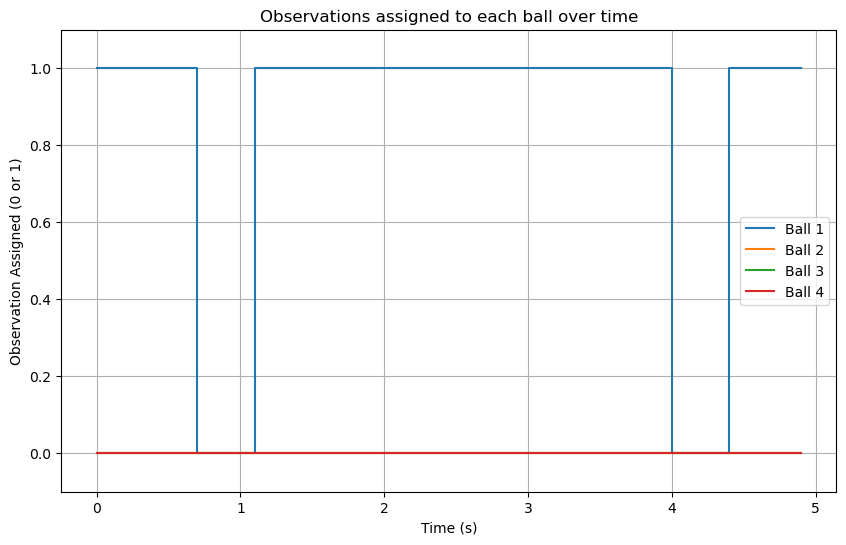

In [42]:
obs_counts = np.zeros((len(t), n_balls))

for time_idx in range(len(t)):
    meas_next = np.array(observations[time_idx]) if time_idx < len(observations) else np.empty((0, 2))
    means_prior = [np.mean([[p.x, p.y] for p in pf], axis=0) for pf in PFs]

    # Active balls that are not in dropout (only those can be assigned observations)
    active_idxs = [i for i in range(n_balls) if not all(p.landed for p in PFs[i]) and not is_sensor_dropout(time_idx)]

    if len(meas_next) > 0 and len(active_idxs) > 0:
        cost_matrix = np.zeros((len(active_idxs), len(meas_next)))
        for i_idx, i in enumerate(active_idxs):
            for j in range(len(meas_next)):
                cost_matrix[i_idx, j] = np.linalg.norm(means_prior[i] - meas_next[j])
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        assignment_map = {active_idxs[row_ind[i]]: col_ind[i] for i in range(len(row_ind))}
    else:
        assignment_map = {}

    # Record if each ball got an assigned observation
    for ball_i in range(n_balls):
        obs_counts[time_idx, ball_i] = 1 if ball_i in assignment_map else 0

# Plot observation presence over time per ball
plt.figure(figsize=(10, 6))
for i in range(n_balls):
    plt.step(t, obs_counts[:, i], where='post', label=f'Ball {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Observation Assigned (0 or 1)')
plt.title('Observations assigned to each ball over time')
plt.ylim(-0.1, 1.1)
plt.legend()
plt.grid(True)
plt.show()
